<a href="https://colab.research.google.com/github/VictorFrancheto/Mathematics_and_Machine_Learning/blob/main/Prova_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)

In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://downloads.skewed.de/apt jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,370 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,593 kB]
Hit:13 https:

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132780 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgr

### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

#### Importando bibliotecas

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

# Importando os métodos de detecção de comunidades do NetworkX
from networkx.algorithms import community as nx_comm
from networkx.algorithms.community import (
    greedy_modularity_communities,  # Método Modularity Greedy
    louvain_communities,            # Método Louvain nativo do NetworkX
    girvan_newman,                  # Método de Girvan-Newman
    label_propagation_communities   # Método de Propagação de Rótulos
)

# Importando o método de Louvain correto do pacote 'community'
import community.community_louvain as community_louvain


#### Função para ler as redes

In [20]:
def process_graph(graph_name, directed=True):
    """
    Processa um grafo da coleção Graph-tool, convertendo-o para um grafo NetworkX,
    removendo auto-laços e imprimindo o número de nós e arestas.

    Parâmetros:
    graph_name (str): Nome do grafo na coleção Graph-tool.
    directed (bool): Se True, cria um grafo direcionado; se False, cria um grafo não direcionado.
    """
    # Carregar o grafo do graph-tool
    G_gt = gt.collection.ns[graph_name]

    # Criar um grafo vazio do NetworkX, direcionado ou não
    G_nx = nx.DiGraph() if directed else nx.Graph()

    # Adicionar arestas do grafo do Graph-tool para o grafo do NetworkX
    for edge in G_gt.edges():
        G_nx.add_edge(edge.source(), edge.target())

    # Remover auto-laços
    G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

    # Ajustando as labels
    G_nx = nx.convert_node_labels_to_integers(G_nx, first_label=0)

    # Obtendo o maior componente conectado
    Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
    G_nx = G_nx.subgraph(Gcc[0])

    # Imprimir o número de nós e arestas
    print(f"Grafo: {graph_name}")
    print("Número de nós:", G_nx.number_of_nodes())
    print("Número de arestas:", G_nx.number_of_edges())

    return G_nx  # Retorna o grafo processado

#### Plotando as redes

Grafo: karate/78
Número de nós: 34
Número de arestas: 78
Grafo: jazz_collab
Número de nós: 198
Número de arestas: 2742
Grafo: polbooks
Número de nós: 105
Número de arestas: 441


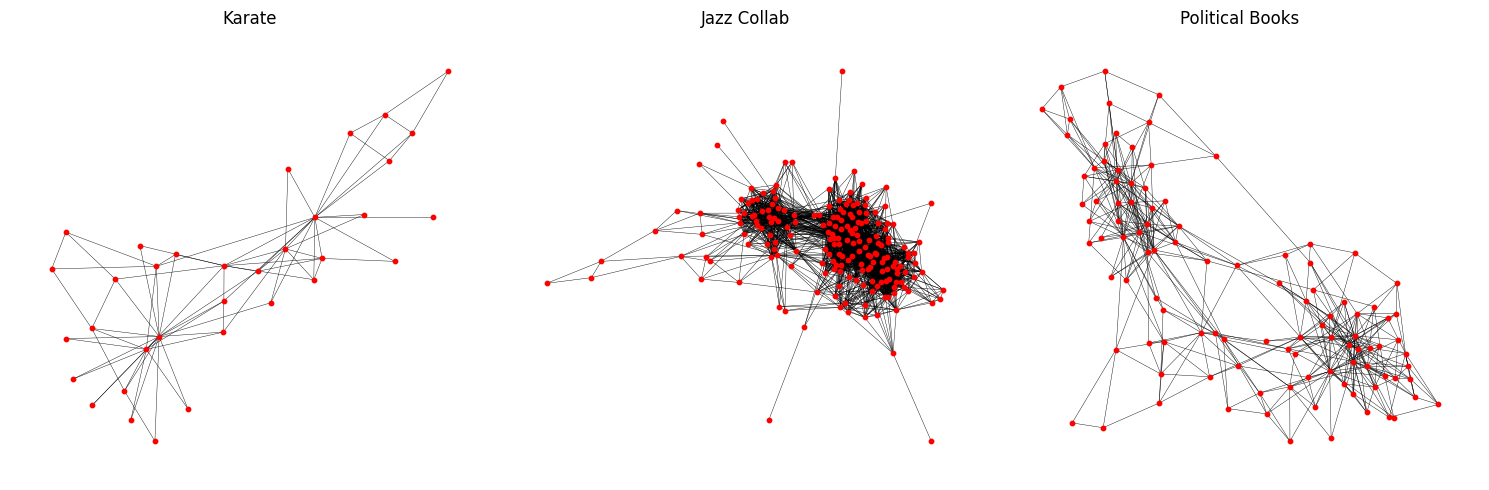

In [44]:
def plot_graph(G_nx, ax, title):
    """
    Função para plotar um grafo em um eixo específico.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo
    nx.draw(
        G_nx, pos,
        ax=ax,
        with_labels=False,  # Remover rótulos
        node_color='red',  # Cor dos nós
        edge_color='black',  # Cor das arestas
        node_size=10,  # Tamanho dos nós
        width=0.3,  # Largura das arestas
        font_size=8,  # Tamanho da fonte dos rótulos
        font_weight='bold',
        arrows=False  # Desabilitar setas para grafos não direcionados
    )
    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # 3 colunas para os subplots

# Processar e plotar os grafos
#G_facebook = process_graph('facebook_friends', directed=False)
G_karate = process_graph('karate/78', directed=False)
G_jazz = process_graph('jazz_collab', directed=False)
G_polbooks = process_graph('polbooks', directed=False)

plot_graph(G_karate, axs[0], "Karate")
plot_graph(G_jazz, axs[1], "Jazz Collab")
plot_graph(G_polbooks, axs[2], "Political Books")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()


# Exercício 1:
Busque 3 redes complexas modelando sistemas reais que possivelmente apresentem estruturas de comunidades. Selecione 3 métodos de detecção de coumidades e identifique as comunidades destas redes.

$a)$ Mostre as comunidades identificadas em cada uma das redes;\
$b)$ Calcule o número de comunidades encontradas em cada uma das redes;\
$c)$ Calcule o valor de modularidade em cada uma das redes. É possível comparar o desempenho de um mesmo método entre redes distintas usando modularidade?\
$d)$ Calcule o quão similar são as patições encontradas por diferentes algoritmos na mesma rede;\
$e)$ Opicional: As inconsistências do item anterior ocorrem na borda das comunidades?

-------------

In [45]:
# Função para desenhar o grafo com as comunidades detectadas
def plot_communities(G_nx, communities, ax, title):
    """
    Função para plotar um grafo com as comunidades detectadas.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    communities (list or dict): Comunidades identificadas, pode ser uma lista de conjuntos ou dicionário de rótulos.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo

    # Se comunidades for um dicionário (ex: Louvain), converta para lista de listas
    if isinstance(communities, dict):
        community_map = communities
    else:
        # Caso contrário, é uma lista de conjuntos (Girvan-Newman e Label Propagation)
        community_map = {node: idx for idx, community in enumerate(communities) for node in community}

    # Extrair as cores com base nas comunidades
    community_values = [community_map[node] for node in G_nx.nodes()]
    num_communities = len(set(community_values))

    # Escolher um conjunto de cores
    cmap = plt.cm.get_cmap('rainbow', num_communities)

    nx.draw(
        G_nx, pos,
        ax=ax,
        node_color=community_values,  # Colorir nós de acordo com a comunidade
        cmap=cmap,  # Usar colormap apropriado
        with_labels=False,  # Remover rótulos
        node_size=50,  # Tamanho dos nós
        edge_color='black',  # Arestas na cor preta
        width=0.5  # Largura das arestas
    )
    ax.set_title(title)  # Título do subplot
    ax.axis('off')  # Ocultar os eixos para melhor visualização

# Função para exibir as comunidades detectadas
def print_communities(communities, method_name):
    """
    Função para printar as comunidades em formato legível.

    Parâmetros:
    communities (list ou dict): Comunidades detectadas.
    method_name (str): Nome do método de detecção de comunidades.
    """
    print(f"\nComunidades detectadas pelo método: {method_name}")

    if isinstance(communities, dict):  # Para Louvain (dicionário)
        # Converter dicionário em lista de listas
        comm_map = {}
        for node, comm in communities.items():
            if comm not in comm_map:
                comm_map[comm] = []
            comm_map[comm].append(node)
        communities = list(comm_map.values())

    # Corrigir caso os nós sejam objetos (ex: Vertex)
    for i, community in enumerate(communities, 1):
        node_ids = [v.index if hasattr(v, 'index') else v for v in community]  # Extraindo IDs corretos
        print(f"Comunidade {i}: {sorted(node_ids)}")

def modularity(G, c):
    A = nx.adjacency_matrix(G)
    N = len(G)
    M = G.number_of_edges()
    Q = 0
    for i in np.arange(0, N):
        ki = len(list(G.neighbors(i)))
        for j in np.arange(0, N):
            if c[i] == c[j]:
                kj = len(list(G.neighbors(j)))
                Q += A[i, j] - (ki * kj) / (2 * M)
    Q /= (2 * M)
    return Q


# Cálculo da modularidade
def calculate_modularity(G, communities):
    if isinstance(communities, dict):
        partition = communities
    else:
        partition = {node: idx for idx, community in enumerate(communities) for node in community}
    return modularity(G, partition)


# Aplicar os métodos de detecção de comunidades
def detect_communities_louvain(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo Louvain.
    """
    return community_louvain.best_partition(G_nx)

def detect_communities_girvan_newman(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo Girvan-Newman.
    """
    comp = girvan_newman(G_nx)
    limited = itertools.takewhile(lambda c: len(c) <= 10, comp)  # Limitar para não ter muitas divisões
    return next(limited)

def detect_communities_label_propagation(G_nx):
    """
    Método de detecção de comunidades utilizando o algoritmo de Propagação de Rótulos.
    """
    return list(label_propagation_communities(G_nx))

#### Comunidades na rede Karate


Comunidades detectadas pelo método: Louvain (Karate)
Comunidade 1: [0, 1, 2, 3, 7, 10, 11, 12, 13, 14, 15, 18]
Comunidade 2: [4, 5, 6, 9, 22]
Comunidade 3: [8, 17, 19, 21, 23, 24, 25, 27, 29, 30, 31, 32, 33]
Comunidade 4: [16, 20, 26, 28]

Comunidades detectadas pelo método: Girvan Newman (Karate)
Comunidade 1: [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 22]
Comunidade 2: [2, 8, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Comunidades detectadas pelo método: Label Propagation (Karate)
Comunidade 1: [0, 1, 2, 3, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Comunidade 2: [4, 9]
Comunidade 3: [5, 6, 22]


<ipython-input-45-e7c4893c2d59>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


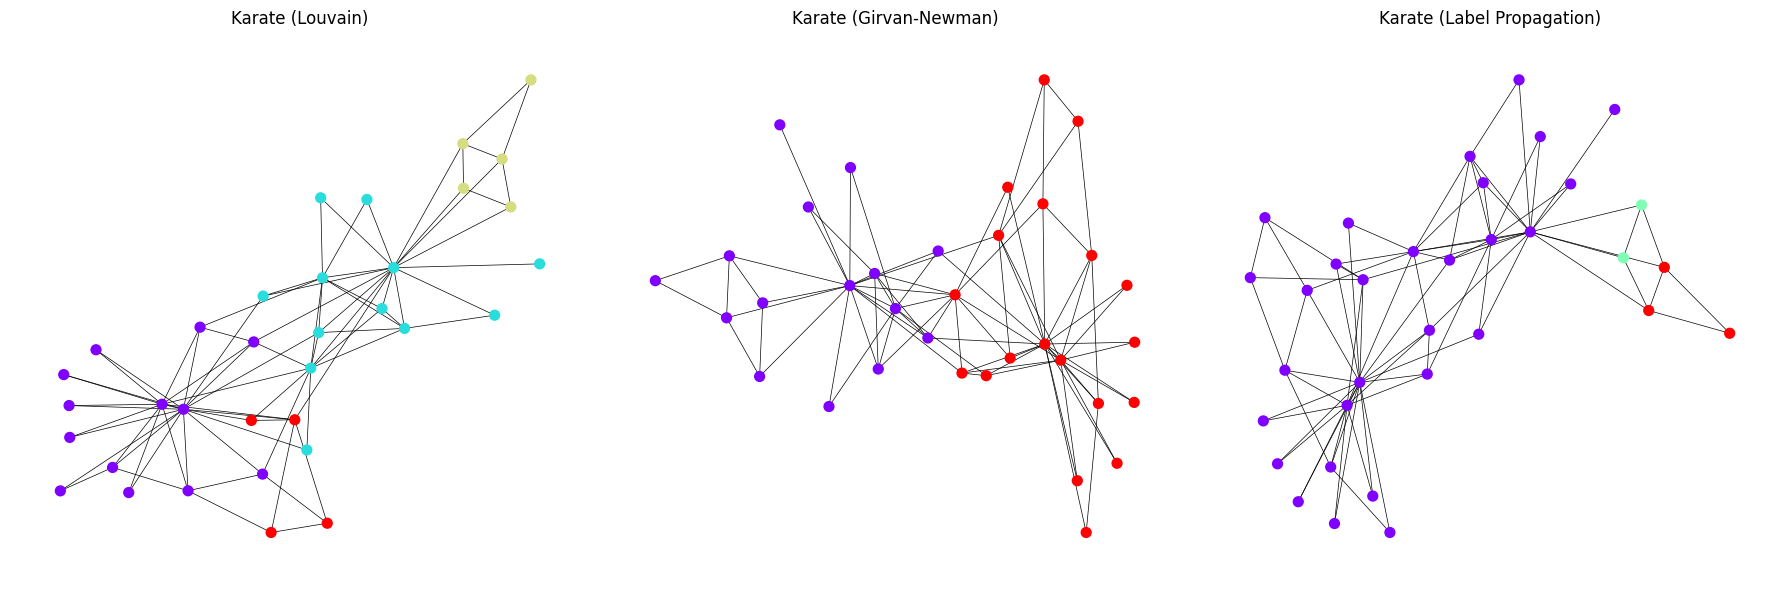

Modularidade de Louvain: 0.41559829059829
Modularidade de Girvan Newman: 0.3599605522682428
Modularidade de Label Propagation: 0.11209730440499684


In [46]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_karate_l = detect_communities_louvain(G_karate)
communities_karate_g = detect_communities_girvan_newman(G_karate)
communities_karate_p = detect_communities_label_propagation(G_karate)

# Printando as comunidades
print_communities(communities_karate_l, "Louvain (Karate)")
print_communities(communities_karate_g, "Girvan Newman (Karate)")
print_communities(communities_karate_p, "Label Propagation (Karate)")

# Plotar os grafos com as comunidades
plot_communities(G_karate, communities_karate_l, axs[0], "Karate (Louvain)")
plot_communities(G_karate, communities_karate_g, axs[1], "Karate (Girvan-Newman)")
plot_communities(G_karate, communities_karate_p, axs[2], "Karate (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()

print(f'Modularidade de Louvain: {calculate_modularity(G_karate, communities_karate_l)}')
print(f'Modularidade de Girvan Newman: {calculate_modularity(G_karate, communities_karate_g)}')
print(f'Modularidade de Label Propagation: {calculate_modularity(G_karate, communities_karate_p)}')

#### Comunidade Jazz Colab


Comunidades detectadas pelo método: Louvain (Jazz Colab)
Comunidade 1: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 89, 92, 161, 170, 171, 172, 175, 176, 178, 179, 180, 183, 184, 186, 191]
Comunidade 2: [7, 15, 24, 29, 30, 53, 58, 60, 61, 62, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 85, 86, 87, 90, 93, 94, 95, 97, 98, 99, 100, 101, 102, 132, 138, 156, 157, 158, 159, 166, 167, 168, 169, 173, 174, 181, 189, 190, 197]
Comunidade 3: [26, 27, 28, 57, 59, 64, 65, 66, 69, 74, 80, 82, 88, 91, 104, 155, 162, 177, 185, 187, 188]
Comunidade 4: [63, 96, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 160, 163, 164, 165, 182, 192, 193, 194, 195, 196]

C

<ipython-input-45-e7c4893c2d59>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


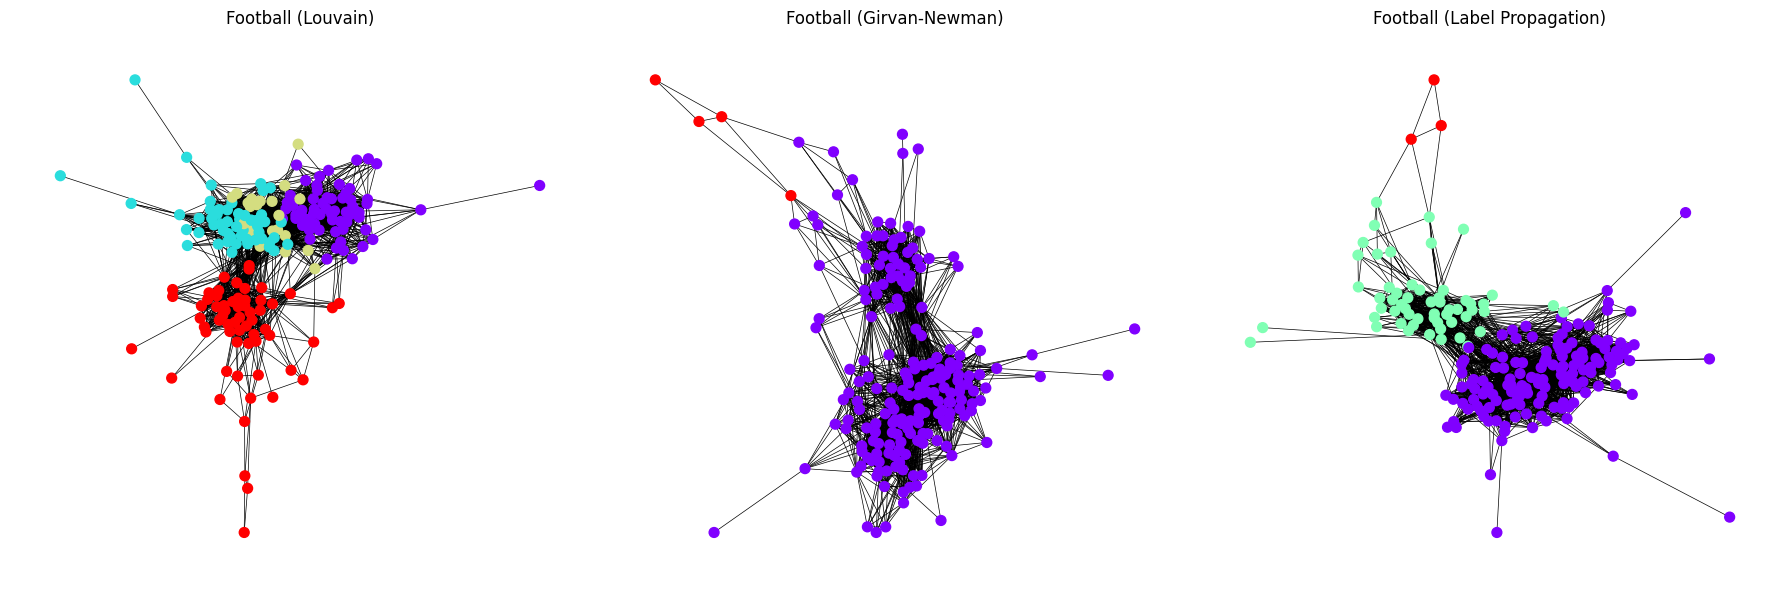

Modularidade de Louvain: 0.4449890298200489
Modularidade de Girvan Newman: 0.0036299484848435846
Modularidade de Label Propagation: 0.28159652561313325


In [48]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_jazz_l = detect_communities_louvain(G_jazz)
communities_jazz_g = detect_communities_girvan_newman(G_jazz)
communities_jazz_p = detect_communities_label_propagation(G_jazz)


# Printando as comunidades
print_communities(communities_jazz_l, "Louvain (Jazz Colab)")
print_communities(communities_jazz_g, "Girvan Newman (Jazz Colab)")
print_communities(communities_jazz_p, "Label Propagation (Jazz Colab)")

# Plotar os grafos com as comunidades
plot_communities(G_jazz, communities_jazz_l, axs[0], "Football (Louvain)")
plot_communities(G_jazz, communities_jazz_g, axs[1], "Football (Girvan-Newman)")
plot_communities(G_jazz, communities_jazz_p, axs[2], "Football (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()

print(f'Modularidade de Louvain: {calculate_modularity(G_jazz, communities_jazz_l)}')
print(f'Modularidade de Girvan Newman: {calculate_modularity(G_jazz, communities_jazz_g)}')
print(f'Modularidade de Label Propagation: {calculate_modularity(G_jazz, communities_jazz_p)}')


Comunidades detectadas pelo método: Louvain (Polbooks)
Comunidade 1: [0, 1, 2, 4, 5, 6, 7, 28, 29]
Comunidade 2: [3, 8, 9, 11, 12, 13, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 32, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57]
Comunidade 3: [10, 15, 16, 19, 33, 34, 35, 36, 37, 38, 39, 55]
Comunidade 4: [30, 31, 59, 60, 61, 62, 63, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Comunidade 5: [51, 52, 58, 64, 65, 67, 68, 69, 85, 103, 104]

Comunidades detectadas pelo método: Girvan Newman (Polbooks)
Comunidade 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 64, 65, 68, 69]
Comunidade 2: [28, 30, 31, 59, 60, 61, 62, 63, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 

<ipython-input-45-e7c4893c2d59>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow', num_communities)


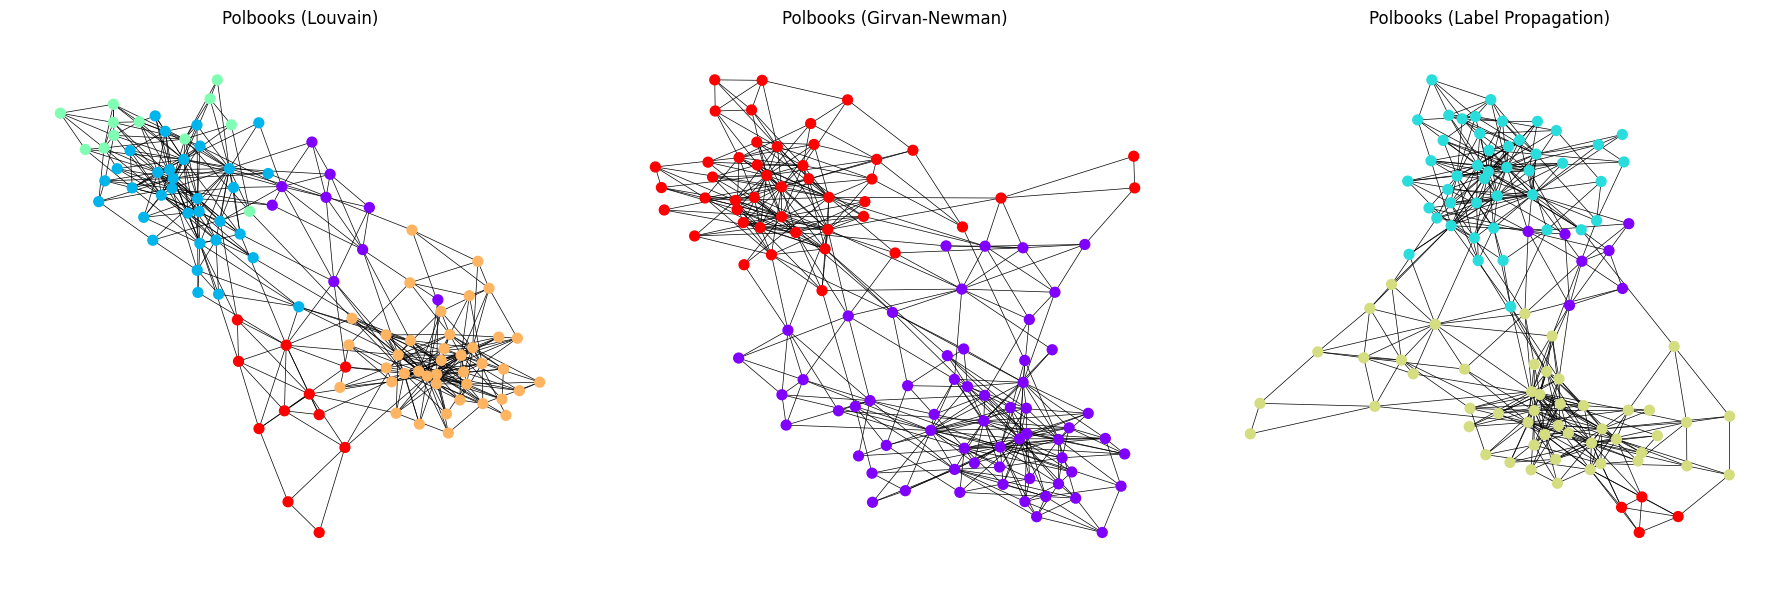

Modularidade de Louvain: 0.5267969621711297
Modularidade de Girvan Newman: 0.44289159352329777
Modularidade de Label Propagation: 0.4811395457654202


In [50]:
# Criar a figura com 3 subplots lado a lado
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))  # 3 colunas para os subplots

# Detectar comunidades usando diferentes métodos
communities_polbooks_l = detect_communities_louvain(G_polbooks)
communities_polbooks_g = detect_communities_girvan_newman(G_polbooks)
communities_polbooks_p = detect_communities_label_propagation(G_polbooks)


# Printando as comunidades
print_communities(communities_polbooks_l, "Louvain (Polbooks)")
print_communities(communities_polbooks_g, "Girvan Newman (Polbooks)")
print_communities(communities_polbooks_p, "Label Propagation (Polbooks)")


# Plotar os grafos com as comunidades
plot_communities(G_polbooks, communities_polbooks_l, axs[0], "Polbooks (Louvain)")
plot_communities(G_polbooks, communities_polbooks_g, axs[1], "Polbooks (Girvan-Newman)")
plot_communities(G_polbooks, communities_polbooks_p, axs[2], "Polbooks (Label Propagation)")

# Mostrar o gráfico
plt.tight_layout()  # Ajustar espaçamento entre os subplots
plt.show()

print(f'Modularidade de Louvain: {calculate_modularity(G_polbooks, communities_polbooks_l)}')
print(f'Modularidade de Girvan Newman: {calculate_modularity(G_polbooks, communities_polbooks_g)}')
print(f'Modularidade de Label Propagation: {calculate_modularity(G_polbooks, communities_polbooks_p)}')

A **modularidade** é uma métrica que avalia a qualidade da divisão de uma rede em **comunidades**, isto é, grupos de nós que têm mais conexões entre si do que com o restante da rede. Portanto, **modularidade** é uma métrica específica para métodos de **detecção de comunidades**.

Se o método que você está avaliando é um método de detecção de comunidades, então sim, você pode usar a modularidade para comparar o desempenho do método em **redes distintas**. No entanto, há algumas limitações e cuidados a serem observados:

### Fatores a Considerar

1. **Dependência do tamanho da rede**:
   A modularidade tende a ser mais alta em redes grandes e densas, simplesmente porque há mais arestas disponíveis para formar comunidades. Redes menores ou esparsas podem ter uma modularidade naturalmente mais baixa, o que pode dificultar comparações diretas entre redes de tamanhos diferentes.

2. **Estrutura e densidade da rede**:
   Redes com diferentes distribuições de grau (por exemplo, redes homogêneas versus redes com hubs) afetam a modularidade de maneira diferente. Redes mais densas podem ter uma modularidade maior porque possuem mais conexões dentro de possíveis comunidades.

3. **Modularidade e resolução**:
   A modularidade tem um limite conhecido como "limite de resolução". Isso significa que em redes muito grandes, o algoritmo de detecção de comunidades pode encontrar comunidades maiores, mesmo que exista uma divisão mais granular que seria mais natural. O inverso acontece em redes pequenas.

4. **Comparação de diferentes tipos de redes**:
   Se as redes são de natureza muito distinta (por exemplo, redes biológicas versus redes sociais), as estruturas inerentes podem gerar modularidades muito diferentes, mesmo que o método utilizado seja o mesmo. Isso pode dificultar a comparação direta, já que redes de tipos diferentes possuem padrões de conexão diferentes.

### Possibilidade de Comparação

Se as redes forem **relativamente comparáveis em termos de tamanho e estrutura**, a modularidade pode ser uma métrica útil para avaliar se o método de detecção de comunidades está funcionando bem em ambas as redes. Entretanto, ao comparar redes muito diferentes, o valor da modularidade por si só pode não ser suficiente para fazer uma comparação justa do desempenho.

### Outras Métricas Complementares

Para obter uma visão mais completa do desempenho de um método em redes distintas, pode ser interessante usar outras métricas de avaliação de comunidades, como:
- **Número de comunidades detectadas**
- **Tamanho médio das comunidades**
- **Homogeneidade ou Coesão das comunidades**
- **Cobertura ou precisão das arestas internas**

Essas métricas podem ajudar a complementar a modularidade, permitindo uma comparação mais robusta entre redes.

Resumindo, sim, é possível usar a modularidade para comparar o desempenho de um método entre redes distintas, mas é importante ter em mente as limitações mencionadas.

#### Rede Karate

In [57]:
# Converter partições em rótulos
labels_louvain = partition_to_labels(G_karate, communities_karate_l)
labels_girvan_newman = partition_to_labels(G_karate, communities_karate_g)
labels_label_propagation = partition_to_labels(G_karate, communities_karate_p)

# Calcular NMI entre comunidades
similarity_metrics = {
    "Louvain vs Girvan-Newman": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_girvan_newman)
    },
    "Louvain vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_label_propagation)
    },
    "Girvan-Newman vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_girvan_newman, labels_label_propagation)
    }
}

# Exibir as similaridades
print("\nSimilaridade entre as partições usando NMI:")
for pair, metrics in similarity_metrics.items():
    print(f"\n{pair}:")
    print(f"  Informação Mútua Normalizada (NMI): {metrics['NMI']:.4f}")


Similaridade entre as partições usando NMI:

Louvain vs Girvan-Newman:
  Informação Mútua Normalizada (NMI): 0.5393

Louvain vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.4678

Girvan-Newman vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.2274


#### Rede Jazz

In [60]:
# Converter partições em rótulos
labels_louvain = partition_to_labels(G_jazz, communities_jazz_l)
labels_girvan_newman = partition_to_labels(G_jazz, communities_jazz_g)
labels_label_propagation = partition_to_labels(G_jazz, communities_jazz_p)

# Calcular NMI entre comunidades
similarity_metrics = {
    "Louvain vs Girvan-Newman": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_girvan_newman)
    },
    "Louvain vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_label_propagation)
    },
    "Girvan-Newman vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_girvan_newman, labels_label_propagation)
    }
}

# Exibir as similaridades
print("\nSimilaridade entre as partições usando NMI:")
for pair, metrics in similarity_metrics.items():
    print(f"\n{pair}:")
    print(f"  Informação Mútua Normalizada (NMI): {metrics['NMI']:.4f}")


Similaridade entre as partições usando NMI:

Louvain vs Girvan-Newman:
  Informação Mútua Normalizada (NMI): 0.0342

Louvain vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.5684

Girvan-Newman vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.1914


In [61]:
# Converter partições em rótulos
labels_louvain = partition_to_labels(G_polbooks, communities_polbooks_l)
labels_girvan_newman = partition_to_labels(G_polbooks, communities_polbooks_g)
labels_label_propagation = partition_to_labels(G_polbooks, communities_polbooks_p)

# Calcular NMI entre comunidades
similarity_metrics = {
    "Louvain vs Girvan-Newman": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_girvan_newman)
    },
    "Louvain vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_louvain, labels_label_propagation)
    },
    "Girvan-Newman vs Label Propagation": {
        "NMI": normalized_mutual_info_score(labels_girvan_newman, labels_label_propagation)
    }
}

# Exibir as similaridades
print("\nSimilaridade entre as partições usando NMI:")
for pair, metrics in similarity_metrics.items():
    print(f"\n{pair}:")
    print(f"  Informação Mútua Normalizada (NMI): {metrics['NMI']:.4f}")


Similaridade entre as partições usando NMI:

Louvain vs Girvan-Newman:
  Informação Mútua Normalizada (NMI): 0.5541

Louvain vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.6976

Girvan-Newman vs Label Propagation:
  Informação Mútua Normalizada (NMI): 0.5569


# Questão 2

Selecione 3 redes complexas adequadas para o cálculo da centralidade de closeness, betweenness, grau hierárquico de primeiro grau e segundo grau.

$a)$ Para cada rede, mostre um scatter plot comparando cada par de medidas de centralidade obtidas nas redes (um gráfico para cada par de medida, para cada uma das redes);

$b)$ Calcule a correlação entre as medidas. Discuta os resultados encontrados.

$c)$ Na rede com estruturas de comunidades, considerando as maiores comunidades, é possível dizer que existe algum vértice com alta relevância dentro da comunidade sem se destacar globalmente?

----------



In [65]:
def calculate_centralities(G):
    """
    Calcula as centralidades de closeness, betweenness, grau de primeiro grau e grau de segundo grau.

    Parâmetros:
    G (networkx.Graph): O grafo para o qual as centralidades serão calculadas.

    Retorna:
    dict: Um dicionário com as centralidades para cada nó.
    """

    # Closeness Centrality (Centralidade de proximidade)
    closeness_centrality = nx.closeness_centrality(G)

    # Betweenness Centrality (Centralidade de intermediação)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Grau de Primeiro Grau (grau direto)
    first_degree_centrality = dict(G.degree())

    # Grau de Segundo Grau (soma dos graus dos vizinhos de cada nó)
    second_degree_centrality = {}
    for node in G.nodes():
        # Para cada nó, somar os graus dos vizinhos
        second_degree_centrality[node] = sum(first_degree_centrality[neighbor] for neighbor in G.neighbors(node))

    # Combine todas as centralidades em um dicionário
    centralities = {
        'closeness': closeness_centrality,
        'betweenness': betweenness_centrality,
        'first_degree': first_degree_centrality,
        'second_degree': second_degree_centrality
    }

    return centralities

centralities_karate = calculate_centralities(G_karate)
centralities_jazz = calculate_centralities(G_jazz)
centralities_polbooks = calculate_centralities(G_polbooks)

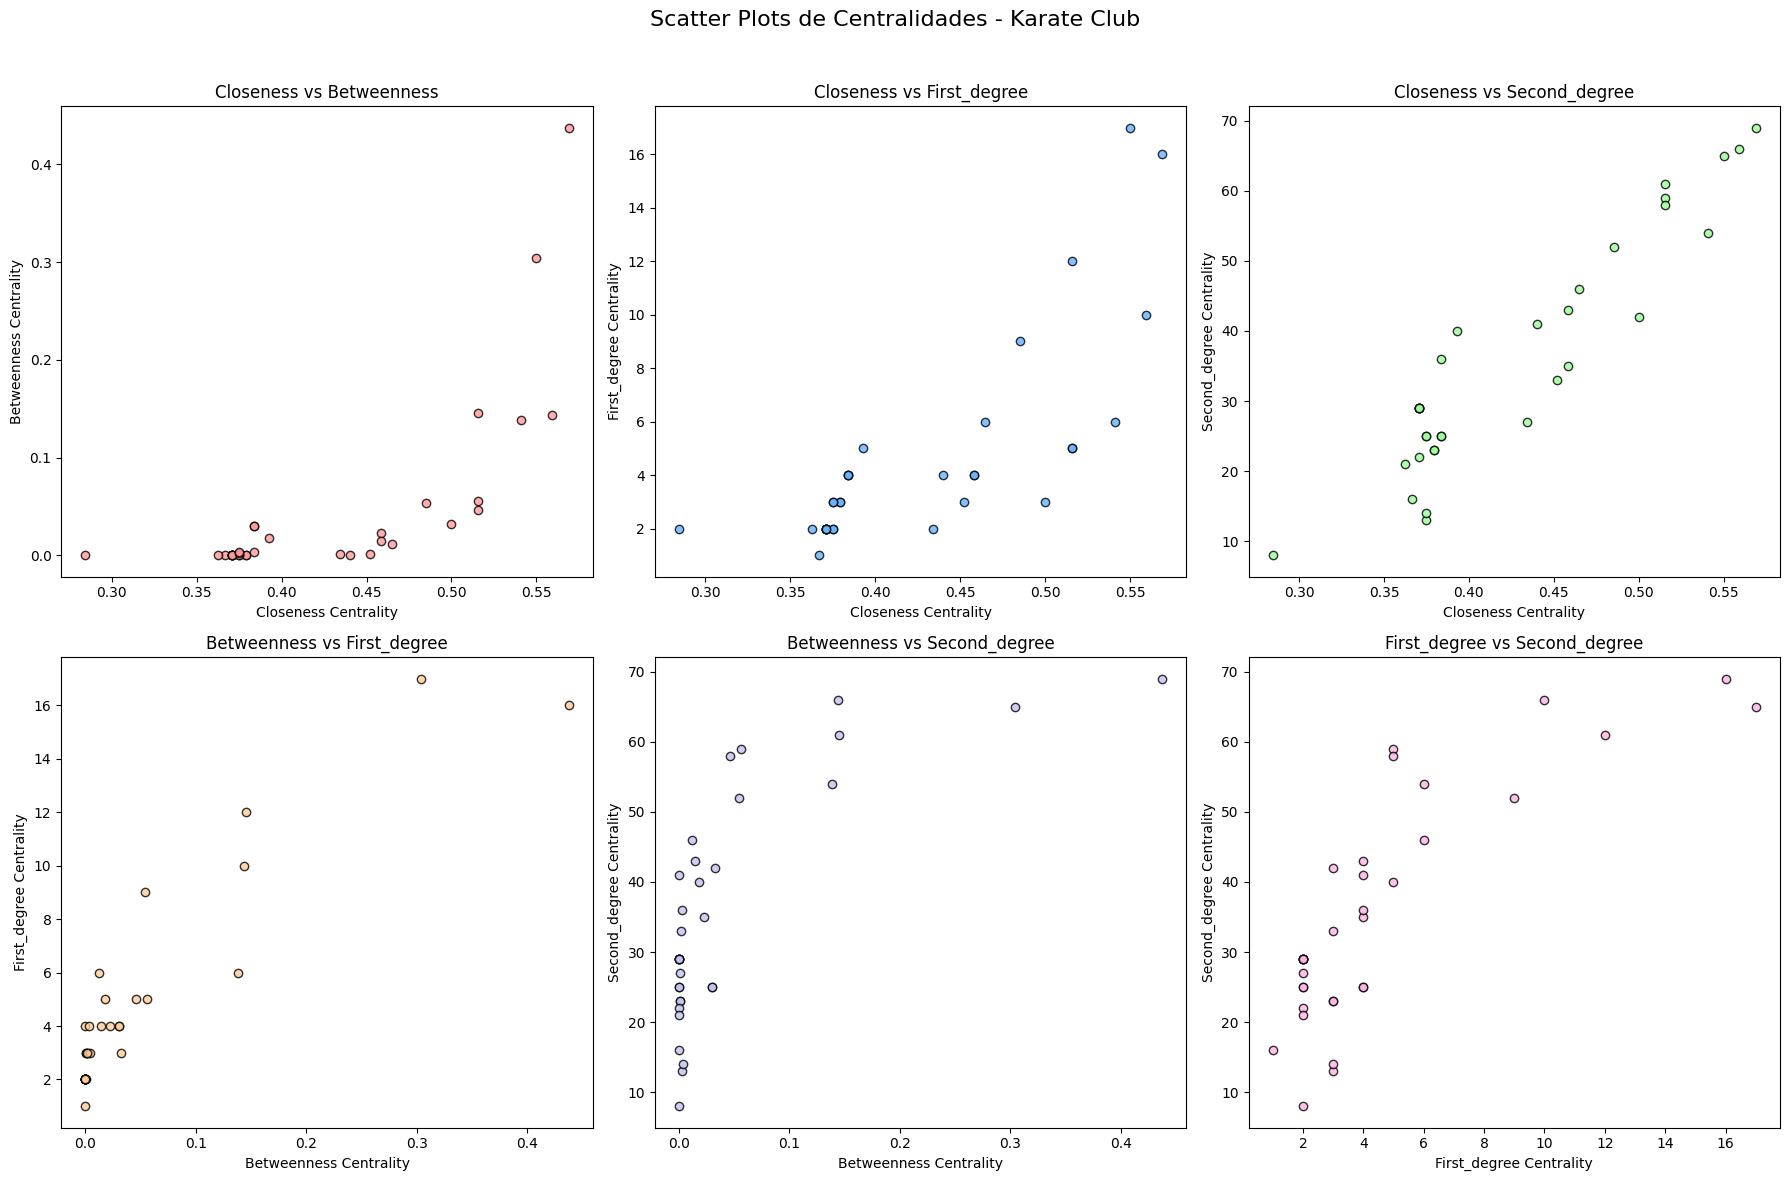

In [71]:
def scatter_plot_centralities(centralities, network_name):
    """
    Gera scatter plots para comparar pares de medidas de centralidade com cores distintas.
    Os gráficos são organizados em 2 linhas e 3 colunas.

    Parâmetros:
    centralities (dict): Dicionário com as centralidades calculadas para uma rede.
    network_name (str): Nome da rede para fins de identificação no título.
    """

    # Extrair os pares de centralidades
    centrality_names = ['closeness', 'betweenness', 'first_degree', 'second_degree']
    centrality_pairs = list(itertools.combinations(centrality_names, 2))

    # Cores distintas
    distinct_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

    # Criar a figura e os subplots com 2 linhas e 3 colunas
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    fig.suptitle(f'Scatter Plots de Centralidades - {network_name}', fontsize=16)

    # Gerar scatter plot para cada par de medidas
    for i, (cent1, cent2) in enumerate(centrality_pairs):
        row = i // 3  # Índice da linha (0 ou 1)
        col = i % 3   # Índice da coluna (0, 1 ou 2)

        # Obter valores das centralidades
        x_values = list(centralities[cent1].values())
        y_values = list(centralities[cent2].values())

        # Usar cor distinta para cada gráfico
        color = distinct_colors[i % len(distinct_colors)]

        # Plotar scatter plot
        axs[row, col].scatter(x_values, y_values, alpha=0.8, c=color, edgecolor='k')
        axs[row, col].set_xlabel(f'{cent1.capitalize()} Centrality')
        axs[row, col].set_ylabel(f'{cent2.capitalize()} Centrality')
        axs[row, col].set_title(f'{cent1.capitalize()} vs {cent2.capitalize()}')

    # Ajustar o layout para espaçamento adequado
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar o layout sem sobrepor o título
    plt.show()

# Exemplo de uso para cada rede
scatter_plot_centralities(centralities_karate, "Karate Club")


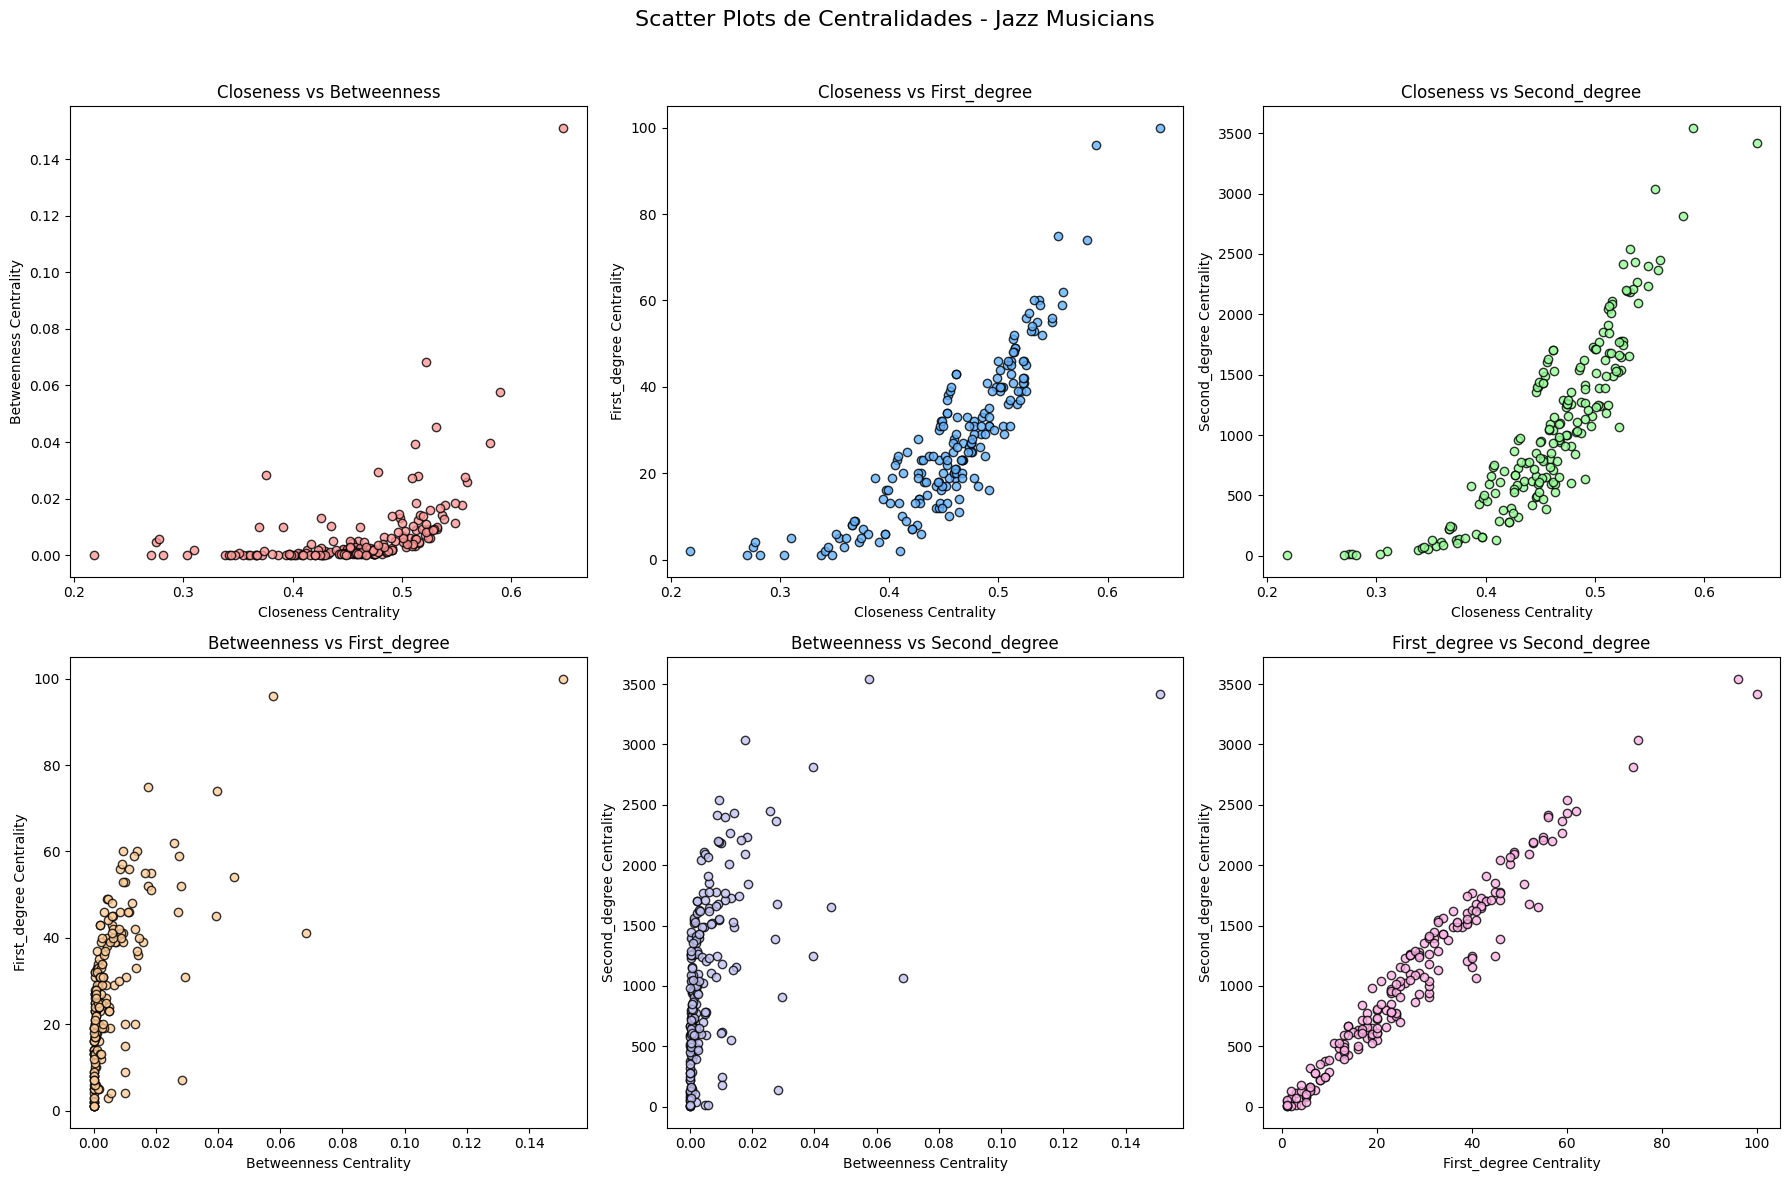

In [72]:
scatter_plot_centralities(centralities_jazz, "Jazz Musicians")

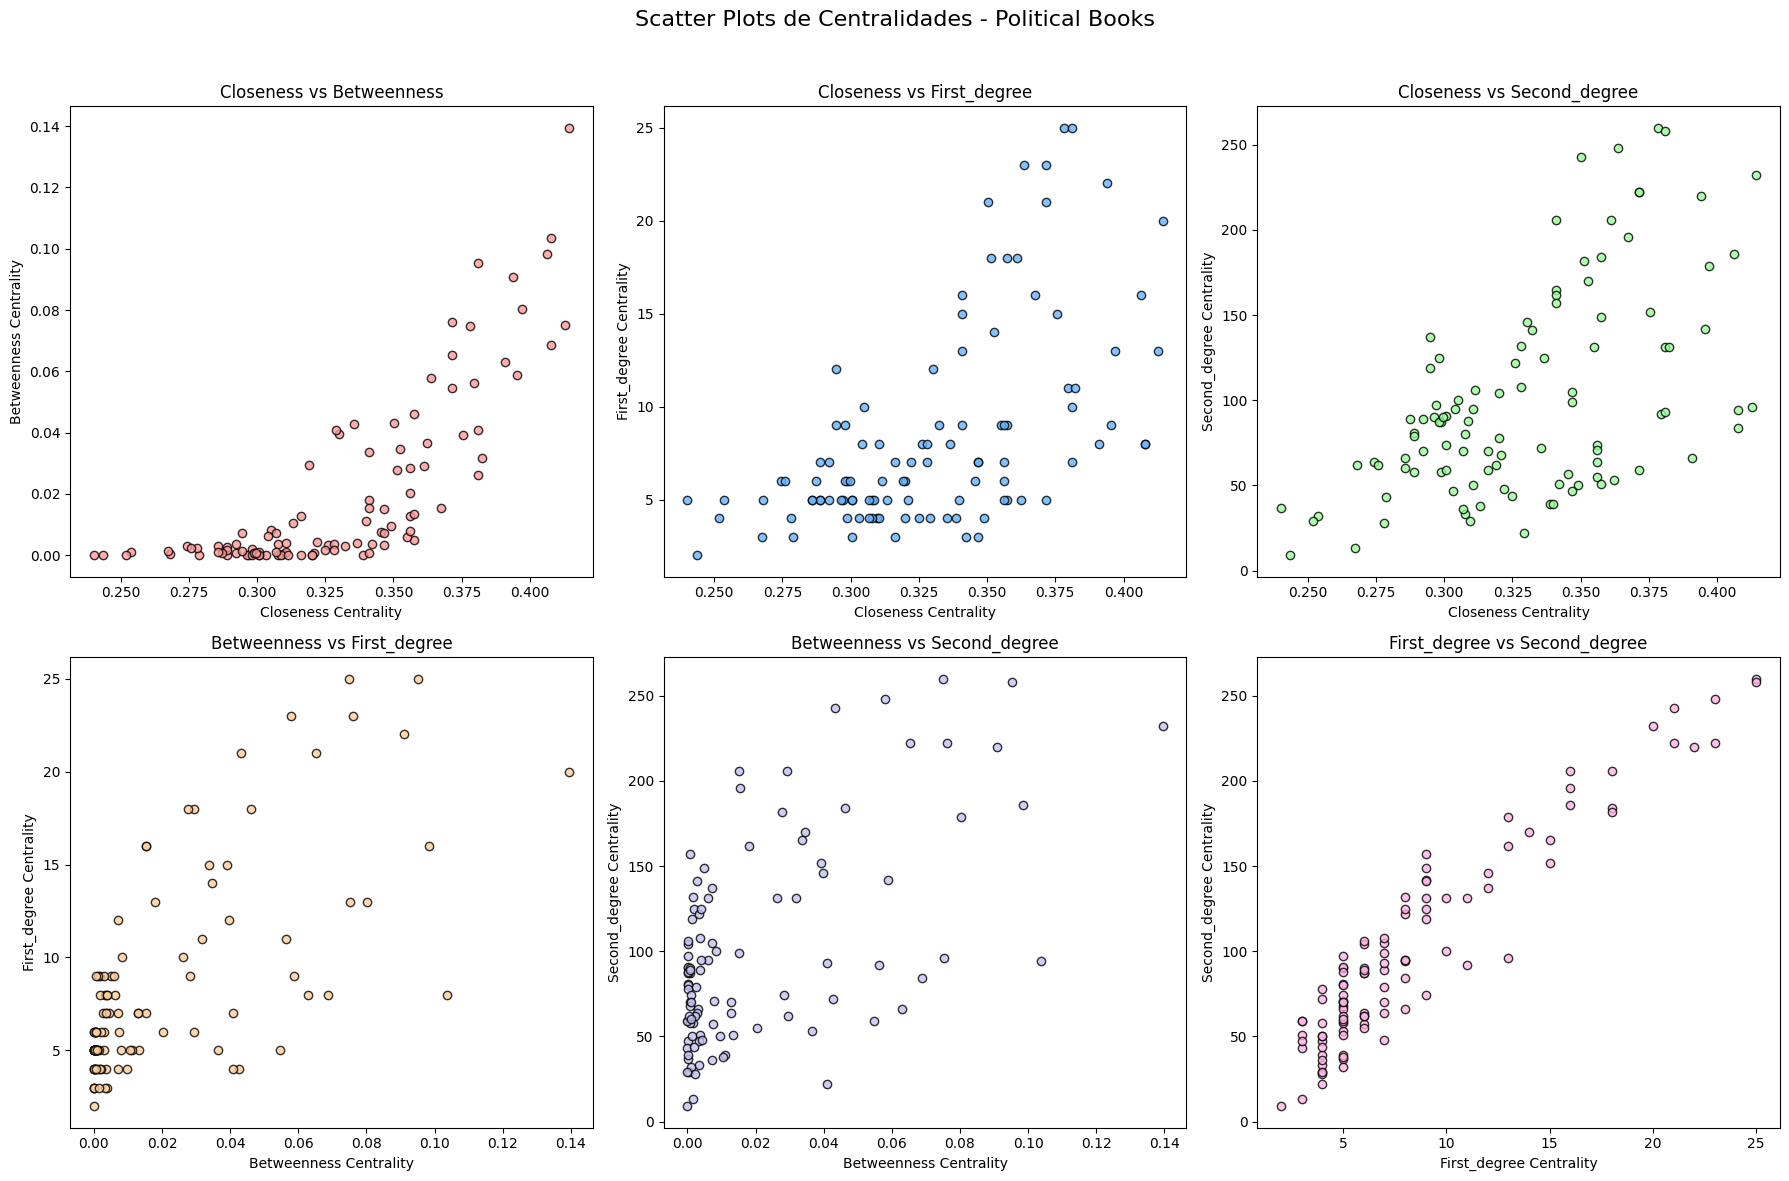

In [73]:
scatter_plot_centralities(centralities_polbooks, "Political Books")

# Letra b)


Matriz de correlação para a rede: Karate Club
               closeness  betweenness  first_degree  second_degree
closeness       1.000000     0.717945      0.771591       0.934006
betweenness     0.717945     1.000000      0.914643       0.721224
first_degree    0.771591     0.914643      1.000000       0.811380
second_degree   0.934006     0.721224      0.811380       1.000000


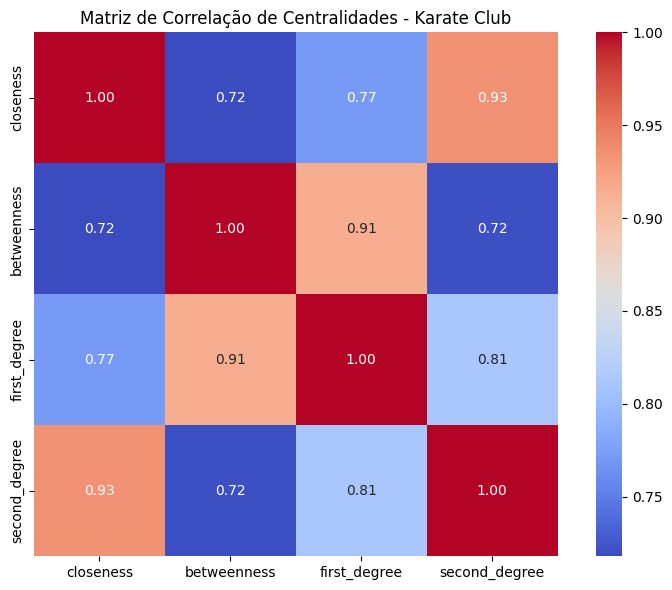


Matriz de correlação para a rede: Jazz Musicians
               closeness  betweenness  first_degree  second_degree
closeness       1.000000     0.474533      0.858711       0.863442
betweenness     0.474533     1.000000      0.605135       0.494073
first_degree    0.858711     0.605135      1.000000       0.975737
second_degree   0.863442     0.494073      0.975737       1.000000


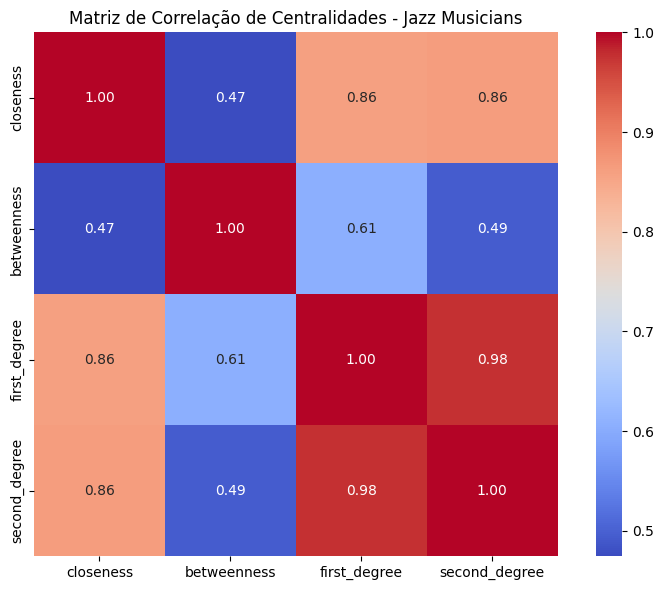


Matriz de correlação para a rede: Political Books
               closeness  betweenness  first_degree  second_degree
closeness       1.000000     0.783787      0.582413       0.561167
betweenness     0.783787     1.000000      0.697132       0.594070
first_degree    0.582413     0.697132      1.000000       0.939054
second_degree   0.561167     0.594070      0.939054       1.000000


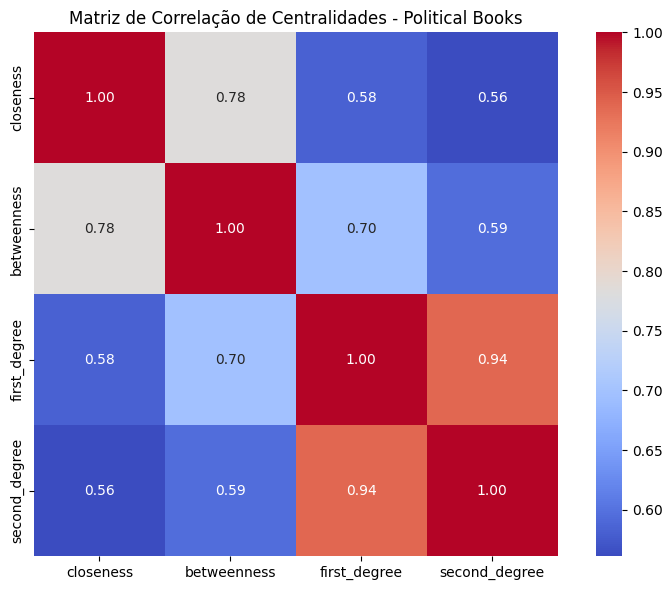

In [74]:
def calculate_correlation(centralities, network_name):
    """
    Calcula a correlação entre as diferentes medidas de centralidade e gera uma matriz de correlação.

    Parâmetros:
    centralities (dict): Dicionário com as centralidades calculadas para uma rede.
    network_name (str): Nome da rede para fins de identificação no título.
    """

    # Converter o dicionário de centralidades em DataFrame para facilitar o cálculo da correlação
    centralities_df = pd.DataFrame(centralities)

    # Calcular a matriz de correlação (Pearson)
    correlation_matrix = centralities_df.corr(method='pearson')

    # Mostrar a matriz de correlação
    print(f"\nMatriz de correlação para a rede: {network_name}")
    print(correlation_matrix)

    # Gerar um heatmap para visualizar a correlação
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
    plt.title(f'Matriz de Correlação de Centralidades - {network_name}')
    plt.tight_layout()
    plt.show()

# Exemplo de uso para calcular e mostrar as correlações para cada rede
calculate_correlation(centralities_karate, "Karate Club")
calculate_correlation(centralities_jazz, "Jazz Musicians")
calculate_correlation(centralities_polbooks, "Political Books")

A matriz de correlação para a rede **Karate Club** revela relações importantes entre as medidas de centralidade. Aqui está uma análise breve dos resultados:

1. **Closeness e Second Degree (Correlação: 0.93)**:
   - A alta correlação entre **closeness** e **grau de segundo grau** sugere que nós com uma alta acessibilidade a outros nós (closeness) também estão ligados a nós que têm muitos vizinhos (grau de segundo grau). Isso faz sentido, já que nós centrais tendem a estar conectados a regiões densas da rede.

2. **Betweenness e First Degree (Correlação: 0.91)**:
   - A correlação forte entre **betweenness** e **grau de primeiro grau** mostra que nós com muitas conexões diretas (grau) também tendem a atuar como intermediários em muitos caminhos curtos (betweenness). No Karate Club, isso sugere que os líderes locais da rede desempenham um papel de mediação importante.

3. **Closeness e Betweenness (Correlação: 0.71)**:
   - Embora a correlação entre **closeness** e **betweenness** seja positiva, ela é moderada. Isso indica que nós centrais, em termos de proximidade, nem sempre são os mais influentes em termos de intermediação. A **betweenness** captura diferentes aspectos da centralidade, como a habilidade de conectar grupos separados.

4. **First Degree e Second Degree (Correlação: 0.81)**:
   - A correlação forte entre **grau de primeiro grau** e **grau de segundo grau** reflete que nós com muitas conexões diretas geralmente estão conectados a outros nós que também têm muitas conexões. Isso reforça a ideia de que nós influentes estão agrupados.

---------------------

A matriz de correlação para a rede **Jazz Musicians** fornece informações importantes sobre como as diferentes medidas de centralidade se relacionam e o que isso pode significar para a estrutura dessa rede de colaboração entre músicos. Vamos analisar cada correlação e o que elas revelam:

### 1. **Closeness e First Degree (Correlação: 0.86)**
   - A alta correlação entre **closeness** e **grau de primeiro grau** indica que os músicos com mais conexões diretas (first degree) também tendem a estar mais próximos de todos os outros músicos da rede. Isso faz sentido em redes de colaboração, já que músicos populares ou bem conectados têm uma posição central na rede e podem rapidamente alcançar outros músicos. Neste caso, a **closeness** sugere que músicos com mais colaborações diretas podem atuar como "pontes" naturais entre diferentes subgrupos da rede.

### 2. **Closeness e Second Degree (Correlação: 0.86)**
   - A correlação entre **closeness** e **grau de segundo grau** é igualmente alta, mostrando que os músicos que estão conectados a outros músicos com muitas colaborações (second degree) também estão bem posicionados na rede como um todo. Em redes de colaboração como essa, músicos com fortes conexões indiretas, através de intermediários bem conectados, também acabam sendo centrais.

### 3. **First Degree e Second Degree (Correlação: 0.98)**
   - A correlação muito alta entre **grau de primeiro grau** e **segundo grau** reflete uma estrutura em que músicos com muitas conexões diretas (first degree) geralmente estão conectados a outros músicos que também têm muitas colaborações (second degree). Isso sugere a existência de "hubs" de músicos que colaboram frequentemente entre si, reforçando a densidade de algumas regiões da rede.

### 4. **Closeness e Betweenness (Correlação: 0.47)**
   - A correlação entre **closeness** e **betweenness** é moderada. Isso indica que nem todos os músicos que estão bem posicionados em termos de proximidade são essenciais para manter a conectividade global da rede. Enquanto **closeness** reflete a acessibilidade média a outros músicos, a **betweenness** captura a importância de certos músicos como intermediários cruciais entre diferentes partes da rede. Músicos que são "pontes" entre comunidades podem não ser necessariamente aqueles mais diretamente conectados a muitos outros.

### 5. **Betweenness e First Degree (Correlação: 0.61)**
   - A correlação moderada entre **betweenness** e **grau de primeiro grau** indica que músicos com muitas colaborações diretas podem ser importantes intermediários, mas isso não é garantido. Enquanto músicos com um alto grau podem ter muitas conexões locais, eles nem sempre são os que mantêm a coesão global da rede (papel capturado pela betweenness). Alguns músicos, apesar de não estarem diretamente conectados a muitos outros, desempenham um papel crucial como "pontes" entre comunidades de músicos.

### 6. **Betweenness e Second Degree (Correlação: 0.49)**
   - A correlação moderada entre **betweenness** e **grau de segundo grau** reforça a ideia de que nem todos os músicos conectados a outros músicos influentes são intermediários cruciais para a conectividade da rede. Isso sugere que a rede pode ter músicos que atuam como hubs locais (com alto second degree), mas não são essenciais para conectar diferentes comunidades.

### Discussão Geral dos Resultados:
Esses resultados indicam que a rede de músicos de jazz é densa e apresenta fortes hubs locais de colaboração. As altas correlações entre **grau de primeiro grau**, **grau de segundo grau** e **closeness** mostram que músicos com muitas conexões diretas estão bem posicionados e próximos de outros músicos. No entanto, a **betweenness** tem correlações mais moderadas com outras métricas, o que sugere que a função de intermediação global na rede não está sempre nas mãos dos músicos mais conectados. Em vez disso, alguns músicos atuam como importantes intermediários, conectando diferentes subgrupos, mesmo sem um número elevado de colaborações diretas.

-----------------

A matriz de correlação para a rede **Political Books** revela como diferentes medidas de centralidade se relacionam dentro da rede de coocorrência de livros políticos. Aqui está uma análise das correlações:

### 1. **Closeness e Betweenness (Correlação: 0.78)**
   - A correlação alta entre **closeness** e **betweenness** sugere que livros que estão mais acessíveis a outros livros na rede (closeness) também tendem a ser aqueles que desempenham um papel importante como intermediários, conectando diferentes regiões da rede (betweenness). Isso significa que os livros que são bem centralizados também têm um papel relevante na intermediação de fluxos de conexões, talvez por serem discutidos ou recomendados em diferentes contextos políticos.

### 2. **First Degree e Second Degree (Correlação: 0.94)**
   - A altíssima correlação entre **grau de primeiro grau** e **grau de segundo grau** indica que livros com muitas conexões diretas (first degree) estão conectados a outros livros igualmente influentes. Isso reflete um padrão de clusters densos, onde livros centrais estão associados a outros que também têm muitas conexões, formando "blocos" temáticos bem conectados.

### 3. **Closeness e First Degree (Correlação: 0.58)**
   - A correlação moderada entre **closeness** e **grau de primeiro grau** sugere que, embora alguns livros com mais conexões diretas estejam bem posicionados na rede (em termos de proximidade a outros livros), essa relação não é tão forte. Alguns livros podem ser bastante conectados localmente, mas não necessariamente mais próximos do resto da rede.

### 4. **Betweenness e First Degree (Correlação: 0.69)**
   - A correlação moderada entre **betweenness** e **grau de primeiro grau** reflete que livros com muitas conexões diretas têm um papel relevante na intermediação da rede, mas isso não é garantido. Alguns livros com muitas conexões diretas podem estar localizados em clusters, sem necessariamente conectar diferentes partes da rede.

### 5. **Closeness e Second Degree (Correlação: 0.56)**
   - A correlação moderada entre **closeness** e **grau de segundo grau** revela que livros conectados a outros livros com muitas conexões podem não ser necessariamente os mais centrais em termos de proximidade a todos os outros livros. Isso sugere que nem todos os livros associados a hubs locais são fundamentais para a conectividade global da rede.

### 6. **Betweenness e Second Degree (Correlação: 0.59)**
   - A correlação moderada entre **betweenness** e **grau de segundo grau** indica que livros conectados a hubs (livros com muitos vizinhos influentes) desempenham um papel intermediário na rede, mas nem sempre são os principais intermediários que conectam regiões distantes.

### Discussão Geral dos Resultados:
Esses resultados indicam que, na rede **Political Books**, as medidas de centralidade se sobrepõem parcialmente, mas cada uma capta diferentes aspectos da relevância dos livros. A alta correlação entre **closeness** e **betweenness** mostra que livros bem posicionados são também importantes para a intermediação. No entanto, a correlação moderada com os graus sugere que os livros mais conectados nem sempre são os mais centrais ou influentes globalmente. Em redes de livros políticos, isso pode significar que alguns livros são mais influentes dentro de comunidades específicas, enquanto outros têm um papel mais global, conectando diversas partes da rede política.



Vértices relevantes na rede Karate que são importantes dentro de suas comunidades, mas não se destacam globalmente:
5
6


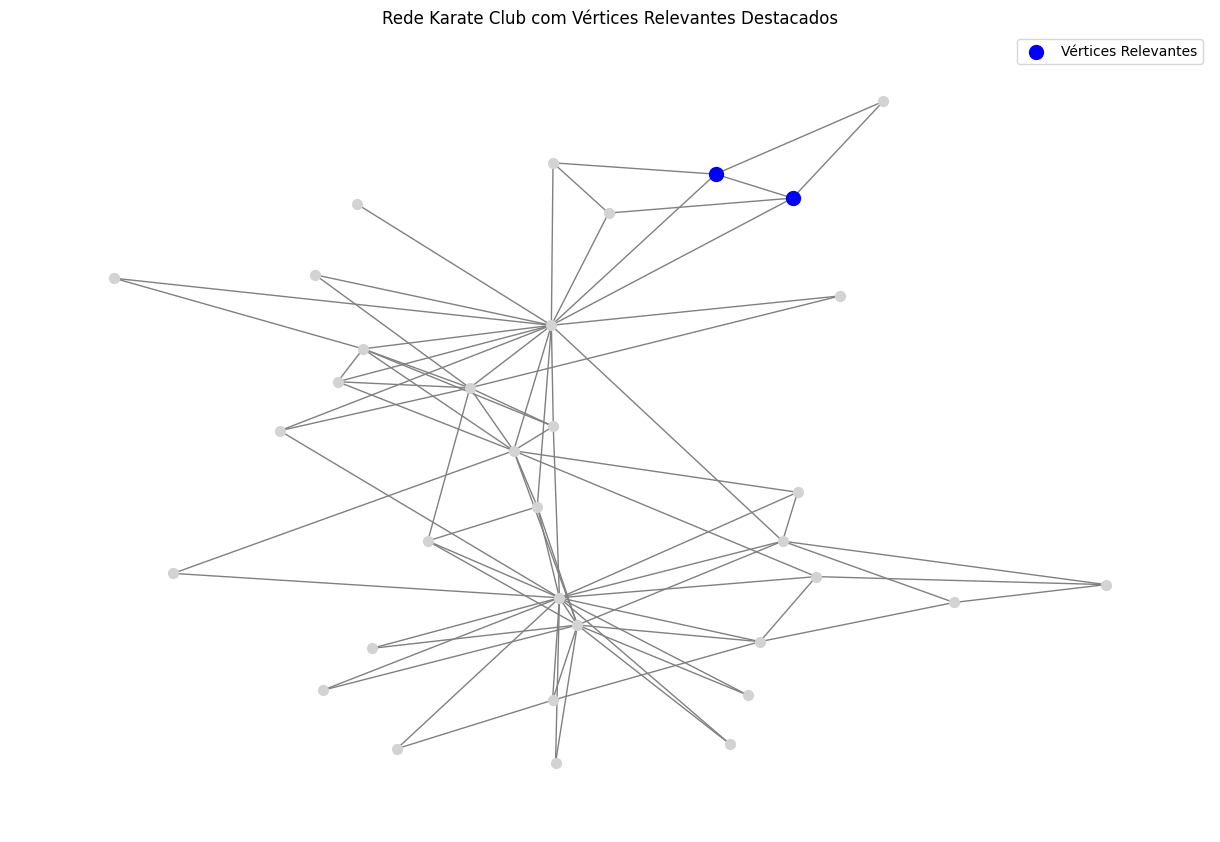

In [78]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Criar ou carregar a rede Karate Club (G_karate)

# Detectar comunidades usando o algoritmo de Propagação de Rótulos
def detect_communities_label_propagation(G):
    return list(community.label_propagation_communities(G))

# Calcular as medidas de centralidade
def calculate_centralities(G):
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    return closeness, betweenness

# Identificar vértices relevantes dentro de comunidades
def find_relevant_vertices(G, communities):
    closeness, betweenness = calculate_centralities(G)

    relevant_vertices = []

    for community in communities:
        community_nodes = list(community)

        closeness_values = [closeness[node] for node in community_nodes]
        betweenness_values = [betweenness[node] for node in community_nodes]

        avg_closeness = np.mean(closeness_values)
        avg_betweenness = np.mean(betweenness_values)

        for node in community_nodes:
            if (closeness[node] > avg_closeness) and (betweenness[node] > avg_betweenness):
                if closeness[node] < np.mean(list(closeness.values())) or betweenness[node] < np.mean(list(betweenness.values())):
                    relevant_vertices.append(node)

    return relevant_vertices

# Função para plotar a rede com vértices destacados
def plot_network_with_relevant_vertices(G, relevant_vertices):
    pos = nx.spring_layout(G)  # Define a posição dos nós

    plt.figure(figsize=(12, 8))

    # Desenhar a rede completa
    nx.draw(G, pos, node_size=50, node_color='lightgray', edge_color='gray', with_labels=False)

    # Desenhar vértices relevantes em azul
    nx.draw_networkx_nodes(G, pos, nodelist=relevant_vertices, node_color='blue', node_size=100, label='Vértices Relevantes')

    plt.title("Rede Karate Club com Vértices Relevantes Destacados")
    plt.axis('off')  # Ocultar eixos
    plt.legend()  # Adicionar legenda
    plt.show()

# Detectar comunidades na rede Karate
communities_karate = detect_communities_label_propagation(G_karate)

# Encontrar vértices relevantes
relevant_vertices_karate = find_relevant_vertices(G_karate, communities_karate)

# Exibir resultados
print("Vértices relevantes na rede Karate que são importantes dentro de suas comunidades, mas não se destacam globalmente:")
for vertex in relevant_vertices_karate:
    print(vertex)

# Plotar a rede Karate com os vértices relevantes
plot_network_with_relevant_vertices(G_karate, relevant_vertices_karate)


Para identificar vértices com alta relevância dentro de suas comunidades sem se destacar globalmente na rede de **Jazz Musicians**, podemos seguir os seguintes passos em Python usando a biblioteca NetworkX:

1. **Detectar Comunidades**: Usaremos o algoritmo de **Propagação de Rótulos** ou outro método adequado para identificar as comunidades na rede.

2. **Calcular Medidas de Centralidade**: Calcular as centralidades de **closeness** e **betweenness** para todos os vértices.

3. **Identificar Vértices Relevantes**: Para cada comunidade, encontramos os vértices com alta centralidade dentro da comunidade, mas baixa centralidade global.


### Explicação do Código:
1. **`detect_communities_label_propagation(G)`**: Esta função usa o algoritmo de propagação de rótulos para detectar comunidades dentro da rede de músicos de jazz.

2. **`calculate_centralities(G)`**: Esta função calcula as centralidades de **closeness** e **betweenness** para todos os vértices na rede.

3. **`find_relevant_vertices(G, communities)`**:
   - Para cada comunidade, ela calcula as médias das centralidades de **closeness** e **betweenness**.
   - Identifica vértices que têm centralidades acima da média local da comunidade, mas abaixo da média global da rede, indicando que são relevantes dentro de suas comunidades, mas não se destacam globalmente.

4. **Resultados**: O código exibe os vértices relevantes encontrados na rede de jazz.

### Nota
Certifique-se de ter a biblioteca **NetworkX** instalada e que a rede de **Jazz Musicians** (`G_jazz`) esteja carregada corretamente antes de executar o código. Se você estiver usando um ambiente de Jupyter Notebook ou um script Python, você poderá visualizar a saída diretamente na célula de código ou no terminal.

Vértices relevantes na rede de Jazz que são importantes dentro de suas comunidades, mas não se destacam globalmente:
23
138
112
111


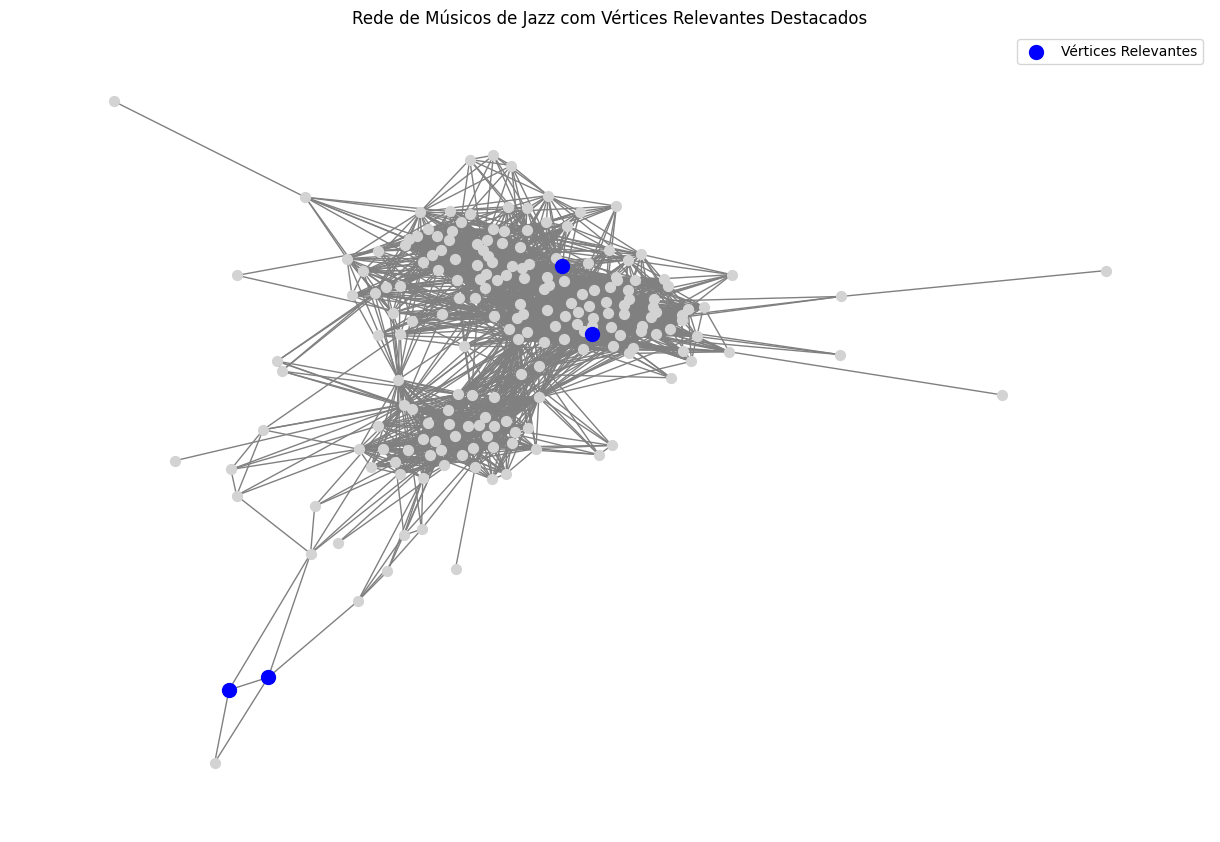

In [79]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Criar ou carregar a rede dos músicos de jazz (G_jazz)

# Detectar comunidades usando o algoritmo de Propagação de Rótulos
def detect_communities_label_propagation(G):
    return list(community.label_propagation_communities(G))

# Calcular as medidas de centralidade
def calculate_centralities(G):
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    return closeness, betweenness

# Identificar vértices relevantes dentro de comunidades
def find_relevant_vertices(G, communities):
    closeness, betweenness = calculate_centralities(G)

    relevant_vertices = []

    for community in communities:
        community_nodes = list(community)

        closeness_values = [closeness[node] for node in community_nodes]
        betweenness_values = [betweenness[node] for node in community_nodes]

        avg_closeness = np.mean(closeness_values)
        avg_betweenness = np.mean(betweenness_values)

        for node in community_nodes:
            if (closeness[node] > avg_closeness) and (betweenness[node] > avg_betweenness):
                if closeness[node] < np.mean(list(closeness.values())) or betweenness[node] < np.mean(list(betweenness.values())):
                    relevant_vertices.append(node)

    return relevant_vertices

# Função para plotar a rede com vértices destacados
def plot_network_with_relevant_vertices(G, relevant_vertices):
    pos = nx.spring_layout(G)  # Define a posição dos nós

    plt.figure(figsize=(12, 8))

    # Desenhar a rede completa
    nx.draw(G, pos, node_size=50, node_color='lightgray', edge_color='gray', with_labels=False)

    # Desenhar vértices relevantes em azul
    nx.draw_networkx_nodes(G, pos, nodelist=relevant_vertices, node_color='blue', node_size=100, label='Vértices Relevantes')

    plt.title("Rede de Músicos de Jazz com Vértices Relevantes Destacados")
    plt.axis('off')  # Ocultar eixos
    plt.legend()  # Adicionar legenda
    plt.show()

# Detectar comunidades
communities_jazz = detect_communities_label_propagation(G_jazz)

# Encontrar vértices relevantes
relevant_vertices_jazz = find_relevant_vertices(G_jazz, communities_jazz)

# Exibir resultados
print("Vértices relevantes na rede de Jazz que são importantes dentro de suas comunidades, mas não se destacam globalmente:")
for vertex in relevant_vertices_jazz:
    print(vertex)

# Plotar a rede com os vértices relevantes
plot_network_with_relevant_vertices(G_jazz, relevant_vertices_jazz)


# Questão 3.
Considere 3 redes complexas sem direção e sem peso.

$a)$ Remova aleatoriamente 30% das arestas. Na rede resultante, calcule a similaridade entre todos os pares de vértices que não estão conectados por arestas. Em seguida, selecione os 30% maiores valores de similaridade. Calcule a correspondência entre essas arestas selecionadas e as arestas originais.

Repita o processo para obter um valor médio da taxa de correspondência (acerto).





In [93]:
def remove_random_edges(G, fraction=0.3):
    """
    Remove uma fração das arestas do grafo G aleatoriamente.

    Parâmetros:
    G (nx.Graph): O grafo do qual as arestas serão removidas.
    fraction (float): A fração de arestas a serem removidas (entre 0 e 1).

    Retorna:
    nx.Graph: O grafo após a remoção de arestas.
    """
    num_edges_to_remove = int(fraction * G.number_of_edges())
    edges = list(G.edges())
    edges_to_remove = random.sample(edges, num_edges_to_remove)
    G.remove_edges_from(edges_to_remove)
    return G

def calculate_similarity(G):
    """
    Calcula a similaridade entre todos os pares de vértices que não estão conectados.

    Parâmetros:
    G (nx.Graph): O grafo para o qual a similaridade será calculada.

    Retorna:
    dict: Dicionário onde as chaves são tuplas de vértices e os valores são os valores de similaridade.
    """
    similarity = {}
    for u, v in combinations(G.nodes(), 2):
        if not G.has_edge(u, v):
            # Calcula a similaridade de Jaccard
            neighbors_u = set(G.neighbors(u))
            neighbors_v = set(G.neighbors(v))
            intersection = len(neighbors_u.intersection(neighbors_v))
            union = len(neighbors_u.union(neighbors_v))
            if union > 0:
                jaccard_index = intersection / union
                similarity[(u, v)] = jaccard_index
    return similarity

def select_top_similarities(similarity_dict, percentage=0.3):
    """
    Seleciona os pares de vértices com os maiores valores de similaridade.

    Parâmetros:
    similarity_dict (dict): Dicionário com valores de similaridade.
    percentage (float): Porcentagem de similaridade a ser selecionada (entre 0 e 1).

    Retorna:
    list: Lista dos pares de vértices com maior similaridade.
    """
    num_to_select = int(percentage * len(similarity_dict))
    top_similarities = sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)[:num_to_select]
    return top_similarities

def calculate_match_rate(original_edges, selected_edges):
    """
    Calcula a taxa de correspondência entre as arestas selecionadas e as arestas originais.

    Parâmetros:
    original_edges (set): Conjunto de arestas originais do grafo.
    selected_edges (list): Lista de arestas selecionadas.

    Retorna:
    float: Taxa de correspondência.
    """
    selected_edge_set = set(pair[0] for pair in selected_edges)  # Converte para um conjunto de pares
    matches = original_edges.intersection(selected_edge_set)
    return len(matches) / len(selected_edge_set) if selected_edge_set else 0

def main_process(graph, iterations=10000):
    original_edges = set(graph.edges())
    match_rates = []

    for _ in range(iterations):
        # Remove aleatoriamente 30% das arestas
        G_temp = remove_random_edges(graph.copy(), fraction=0.3)

        # Calcula a similaridade
        similarity_dict = calculate_similarity(G_temp)

        # Seleciona os 30% maiores valores de similaridade
        selected_edges = select_top_similarities(similarity_dict)

        # Calcula a taxa de correspondência
        match_rate = calculate_match_rate(original_edges, selected_edges)
        match_rates.append(match_rate)

    # Calcula a média da taxa de correspondência
    average_match_rate = sum(match_rates) / len(match_rates)
    return average_match_rate

# Executa o processo principal
average_match_rate = main_process(G_jazz, iterations=10000)
print("Taxa média de correspondência:", average_match_rate)


Taxa média de correspondência: 0.14953621465417608


Para realizar o que você descreveu, vamos dividir o processo em etapas:

1. **Remover aleatoriamente 30% das arestas do grafo.**
2. **Calcular a similaridade entre todos os pares de vértices não conectados.**
3. **Selecionar os 30% maiores valores de similaridade.**
4. **Calcular a correspondência entre as arestas selecionadas e as arestas originais.**
5. **Repetir o processo várias vezes para obter um valor médio da taxa de correspondência.**

Vamos começar implementando essas etapas em código. Vou usar a similaridade de Jaccard como uma métrica para calcular a similaridade entre os pares de vértices. Para isso, precisamos de algumas bibliotecas: `networkx` e `random`.

Aqui está o código que segue essas etapas:

```python
import random
import networkx as nx
from itertools import combinations

def remove_random_edges(G, fraction=0.3):
    """
    Remove uma fração das arestas do grafo G aleatoriamente.
    
    Parâmetros:
    G (nx.Graph): O grafo do qual as arestas serão removidas.
    fraction (float): A fração de arestas a serem removidas (entre 0 e 1).
    
    Retorna:
    nx.Graph: O grafo após a remoção de arestas.
    """
    num_edges_to_remove = int(fraction * G.number_of_edges())
    edges = list(G.edges())
    edges_to_remove = random.sample(edges, num_edges_to_remove)
    G.remove_edges_from(edges_to_remove)
    return G

def calculate_similarity(G):
    """
    Calcula a similaridade entre todos os pares de vértices que não estão conectados.
    
    Parâmetros:
    G (nx.Graph): O grafo para o qual a similaridade será calculada.
    
    Retorna:
    dict: Dicionário onde as chaves são tuplas de vértices e os valores são os valores de similaridade.
    """
    similarity = {}
    for u, v in combinations(G.nodes(), 2):
        if not G.has_edge(u, v):
            # Calcula a similaridade de Jaccard
            neighbors_u = set(G.neighbors(u))
            neighbors_v = set(G.neighbors(v))
            intersection = len(neighbors_u.intersection(neighbors_v))
            union = len(neighbors_u.union(neighbors_v))
            if union > 0:
                jaccard_index = intersection / union
                similarity[(u, v)] = jaccard_index
    return similarity

def select_top_similarities(similarity_dict, percentage=0.3):
    """
    Seleciona os pares de vértices com os maiores valores de similaridade.
    
    Parâmetros:
    similarity_dict (dict): Dicionário com valores de similaridade.
    percentage (float): Porcentagem de similaridade a ser selecionada (entre 0 e 1).
    
    Retorna:
    list: Lista dos pares de vértices com maior similaridade.
    """
    num_to_select = int(percentage * len(similarity_dict))
    top_similarities = sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True)[:num_to_select]
    return top_similarities

def calculate_match_rate(original_edges, selected_edges):
    """
    Calcula a taxa de correspondência entre as arestas selecionadas e as arestas originais.
    
    Parâmetros:
    original_edges (set): Conjunto de arestas originais do grafo.
    selected_edges (list): Lista de arestas selecionadas.
    
    Retorna:
    float: Taxa de correspondência.
    """
    selected_edge_set = set(pair[0] for pair in selected_edges)  # Converte para um conjunto de pares
    matches = original_edges.intersection(selected_edge_set)
    return len(matches) / len(selected_edge_set) if selected_edge_set else 0

def main_process(graph, iterations=10):
    original_edges = set(graph.edges())
    match_rates = []
    
    for _ in range(iterations):
        # Remove aleatoriamente 30% das arestas
        G_temp = remove_random_edges(graph.copy(), fraction=0.3)
        
        # Calcula a similaridade
        similarity_dict = calculate_similarity(G_temp)
        
        # Seleciona os 30% maiores valores de similaridade
        selected_edges = select_top_similarities(similarity_dict)
        
        # Calcula a taxa de correspondência
        match_rate = calculate_match_rate(original_edges, selected_edges)
        match_rates.append(match_rate)
    
    # Calcula a média da taxa de correspondência
    average_match_rate = sum(match_rates) / len(match_rates)
    return average_match_rate

# Executa o processo principal
average_match_rate = main_process(G_polbooks, iterations=10)
print("Taxa média de correspondência:", average_match_rate)
```

### Explicação do Código
- **`remove_random_edges`**: Remove aleatoriamente uma fração especificada das arestas do grafo.
- **`calculate_similarity`**: Calcula a similaridade de Jaccard entre todos os pares de nós não conectados.
- **`select_top_similarities`**: Seleciona os pares com os maiores valores de similaridade.
- **`calculate_match_rate`**: Calcula a taxa de correspondência entre as arestas selecionadas e as arestas originais.
- **`main_process`**: Coordena as etapas, repetindo o processo de remoção de arestas e cálculo de correspondência várias vezes, e finalmente calcula a média da taxa de correspondência.

### Considerações
- O número de iterações pode ser ajustado de acordo com a necessidade para obter uma média mais confiável.
- A métrica de similaridade pode ser alterada, se desejado, para outras que melhor atendam às suas necessidades.

Sinta-se à vontade para modificar ou testar o código conforme necessário!

# Letra b)
A tarefa anterior relaciona-se com a previsão de links em redes complexas.  
Em uma rede estruturada em comunidades, discuta como essa mesma tarefa poderia se tornar mais eficiente computacionalmente em comparação a redes não baseadas em comunidades.

--------------------
A previsão de links em redes complexas é uma tarefa crucial, especialmente em contextos como redes sociais, biológicas e de comunicação. Quando se compara a previsão de links em redes que são estruturadas em comunidades com redes que não possuem tal estrutura, algumas vantagens e abordagens eficientes podem ser identificadas:

### 1. **Estrutura das Comunidades**
   - **Redes Baseadas em Comunidades**: Essas redes apresentam grupos de nós que são mais densamente conectados entre si do que com nós em outras comunidades. Essa característica permite que algoritmos de previsão de links se concentrem em analisar conexões dentro e entre comunidades, potencialmente reduzindo o espaço de busca.
   - **Redes Não Baseadas em Comunidades**: Em redes mais aleatórias ou uniformes, a conexão entre todos os pares de nós deve ser considerada, aumentando a complexidade computacional.

### 2. **Aproveitamento de Similaridades Locais**
   - **Comunidades**: Dentro de uma comunidade, é provável que haja padrões de conexão similares (por exemplo, o teorema dos triângulos). Assim, técnicas de similaridade, como a Similaridade de Jaccard, podem ser aplicadas de forma mais eficaz, utilizando as interações locais para prever novas conexões.
   - **Redes Não Estruturadas**: A previsão de links precisaria considerar todas as interações possíveis entre pares de nós, o que pode ser muito mais custoso em termos computacionais.

### 3. **Redução do Espaço de Busca**
   - **Enfoque Local**: Em redes comunitárias, ao prever links, pode-se focar nas arestas que conectam nós dentro da mesma comunidade ou entre comunidades adjacentes. Isso reduz significativamente o número de pares de nós a serem avaliados.
   - **Redes Não Estruturadas**: Sem comunidades definidas, o algoritmo precisa avaliar um número maior de pares de nós, aumentando a carga computacional.

### 4. **Algoritmos Adaptativos**
   - **Exploitação de Estruturas Comunitárias**: Algoritmos podem ser adaptados para usar características das comunidades, como a densidade de conexões dentro da comunidade, a proximidade geográfica, ou atributos dos nós, para melhorar a previsão de links.
   - **Redes Não Estruturadas**: Algoritmos adaptativos podem ser menos eficientes, pois não há padrões claros a serem explorados.

### 5. **Aprimoramento da Análise de Similaridade**
   - **Métricas de Similaridade**: Em redes baseadas em comunidades, as métricas de similaridade podem ser aprimoradas utilizando informações sobre a estrutura comunitária. Por exemplo, a similaridade entre nós em comunidades diferentes pode ser ponderada com base na força das conexões entre as comunidades.
   - **Redes Não Estruturadas**: As métricas de similaridade podem não capturar efetivamente as relações entre os nós, tornando a previsão menos precisa.

### 6. **Eficiência de Algoritmos de Detecção de Comunidades**
   - **Detecção e Previsão de Links**: Ao utilizar algoritmos de detecção de comunidades (como Louvain ou Girvan-Newman), os resultados podem ser usados para melhorar a previsão de links, limitando a análise às comunidades mais relevantes.
   - **Redes Não Estruturadas**: Sem uma estrutura de comunidade, os algoritmos de detecção de comunidades não são aplicáveis, e os métodos de previsão de links podem ser menos eficazes.

### Conclusão
Em suma, a previsão de links em redes estruturadas em comunidades pode se tornar mais eficiente computacionalmente ao tirar proveito da estrutura subjacente da rede. A identificação de padrões locais, a redução do espaço de busca e a adaptação de algoritmos para explorar características comunitárias oferecem vantagens significativas. Por outro lado, em redes não baseadas em comunidades, a falta de estrutura e padrão pode levar a uma maior complexidade computacional e menor precisão nas previsões.

# Exercício 4.



A afirmação de que "o particionamento de redes parece equivalente ao problema de detecção de comunidades quando se trabalha com bi-partição" não é totalmente verdadeira, apesar de haver uma relação entre os dois problemas. Vou explicar as diferenças e, em seguida, dar um exemplo.

### Diferença entre bissecção de grafos e detecção de comunidades

**Bissecção de grafos (Graph Bisection):** O problema da bissecção de grafos consiste em dividir o grafo em dois grupos (ou subconjuntos) de tamanhos iguais ou quase iguais, de forma a minimizar o **cut-size** — ou seja, o número de arestas que conectam vértices de grupos diferentes. Aqui, o foco está em balancear o tamanho dos dois grupos e minimizar as conexões entre eles.

**Detecção de comunidades:** A detecção de comunidades visa identificar subconjuntos de vértices altamente interconectados dentro de uma rede. O objetivo é maximizar a densidade de conexões dentro de um grupo (ou comunidade) e minimizar as conexões entre grupos, sem a restrição de que os grupos sejam de tamanho igual ou balanceado. É um problema mais geral e pode resultar em mais de dois clusters.

### Diferenças principais:
1. **Restrição de balanceamento:** Na bissecção, é necessário que os dois grupos tenham tamanhos iguais ou quase iguais, enquanto na detecção de comunidades, os tamanhos dos grupos podem variar livremente.
   
2. **Número de grupos:** A bissecção trabalha com dois grupos (bi-partição), enquanto a detecção de comunidades pode resultar em dois ou mais grupos.

3. **Objetivo principal:** O foco da bissecção está em minimizar o número de arestas entre os grupos, enquanto a detecção de comunidades foca em encontrar grupos densos internamente, independentemente do número de arestas entre eles.

### Exemplo

Considere um grafo com três comunidades distintas: um grupo de 10 vértices altamente interconectados (A), outro grupo de 10 vértices densamente conectados entre si (B), e um terceiro grupo menor de 5 vértices (C), também bem interconectados. Existem algumas poucas arestas entre A, B e C.

1. **Detecção de comunidades:** A solução ideal seria identificar três grupos: A, B e C, porque os vértices dentro de cada um desses grupos têm mais conexões entre si do que com os vértices de outros grupos.

2. **Bissecção de grafos:** Nesse caso, como o objetivo é dividir o grafo em dois grupos, um possível resultado seria colocar A e parte de B em um grupo, e o restante de B e C no outro. Isso minimiza o número de arestas entre os dois grupos, mas não reflete adequadamente a estrutura real das comunidades.

### Conclusão

A bissecção de grafos e a detecção de comunidades estão relacionadas, pois ambos os problemas buscam minimizar as arestas entre grupos e maximizar as conexões dentro dos grupos. Contudo, eles não são equivalentes, pois a bissecção impõe restrições adicionais, como o balanceamento de tamanho e o número fixo de grupos (dois). A detecção de comunidades é mais flexível e, portanto, pode capturar melhor a estrutura real das redes em muitos casos.

In [95]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.approximation import minimum_edge_cut

# Criação do grafo
G = nx.Graph()

# Adicionando nós e arestas para três comunidades
# Comunidade A (10 nós)
nodes_A = range(10)
edges_A = [(i, j) for i in nodes_A for j in nodes_A if i != j]
G.add_edges_from(edges_A)

# Comunidade B (10 nós)
nodes_B = range(10, 20)
edges_B = [(i, j) for i in nodes_B for j in nodes_B if i != j]
G.add_edges_from(edges_B)

# Comunidade C (5 nós)
nodes_C = range(20, 25)
edges_C = [(i, j) for i in nodes_C for j in nodes_C if i != j]
G.add_edges_from(edges_C)

# Adicionando algumas arestas entre as comunidades
inter_community_edges = [(2, 12), (3, 21), (15, 22), (8, 19), (0, 23)]
G.add_edges_from(inter_community_edges)

# Função para desenhar o grafo
def draw_graph(G, pos=None, title="Grafo"):
    if not pos:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(title)
    plt.show()

# Desenhar o grafo original
draw_graph(G, title="Grafo Original com 3 Comunidades")

# --- Bissecção de grafos ---
cut_edges = minimum_edge_cut(G)
cut_value = len(cut_edges)

# Remover arestas da bissecção
G_bisection = G.copy()
G_bisection.remove_edges_from(cut_edges)

# Desenhar grafo após a bissecção
draw_graph(G_bisection, title="Grafo após Bissecção")

print(f"Bissecção: {cut_value} arestas cortadas: {cut_edges}")

# --- Detecção de Comunidades ---
communities = list(greedy_modularity_communities(G))
print(f"Detecção de Comunidades: {len(communities)} comunidades")

# Desenhar grafo com comunidades
def draw_communities(G, communities):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 8))
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink']

    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i % len(colors)], label=f"Comunidade {i+1}", node_size=500)

    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos)

    plt.title("Grafo com Detecção de Comunidades")
    plt.legend()
    plt.show()

draw_communities(G, communities)


ImportError: cannot import name 'minimum_edge_cut' from 'networkx.algorithms.approximation' (/usr/local/lib/python3.10/dist-packages/networkx/algorithms/approximation/__init__.py)

Aqui está um exemplo em Python que simula o problema descrito, usando bibliotecas como **NetworkX** para manipulação de grafos e **community** para detecção de comunidades:

Neste exemplo, criaremos um grafo com três comunidades interconectadas e aplicaremos tanto a bissecção de grafos quanto a detecção de comunidades, destacando as diferenças.

### Explicação:

1. **Criação do Grafo:**
   - Três comunidades são criadas: A (nós 0-9), B (nós 10-19), e C (nós 20-24), com alta conectividade interna.
   - Algumas arestas são adicionadas entre essas comunidades.

2. **Bissecção de Grafos:**
   - Usamos a função `minimum_edge_cut` para dividir o grafo em duas partes, minimizando o número de arestas entre elas. O grafo é desenhado após a bissecção.

3. **Detecção de Comunidades:**
   - Usamos o algoritmo de modularidade gulosa (`greedy_modularity_communities`) para detectar comunidades no grafo. O grafo é redesenhado com as comunidades destacadas.

### Saídas:
- A bissecção tentará dividir o grafo em dois subconjuntos balanceados.
- A detecção de comunidades identificará três comunidades mais coerentes com a estrutura real do grafo.

Experimente rodar o código para visualizar as diferenças!

# Exercício 5.

Encontre a melhor bi-secção da rede Zachary's karate club (G_karate) aplicando o método Kernighan-Lin. Compare os resultados da bipartição com a partição natural da rede e mostre onde há diferenças e similaridades

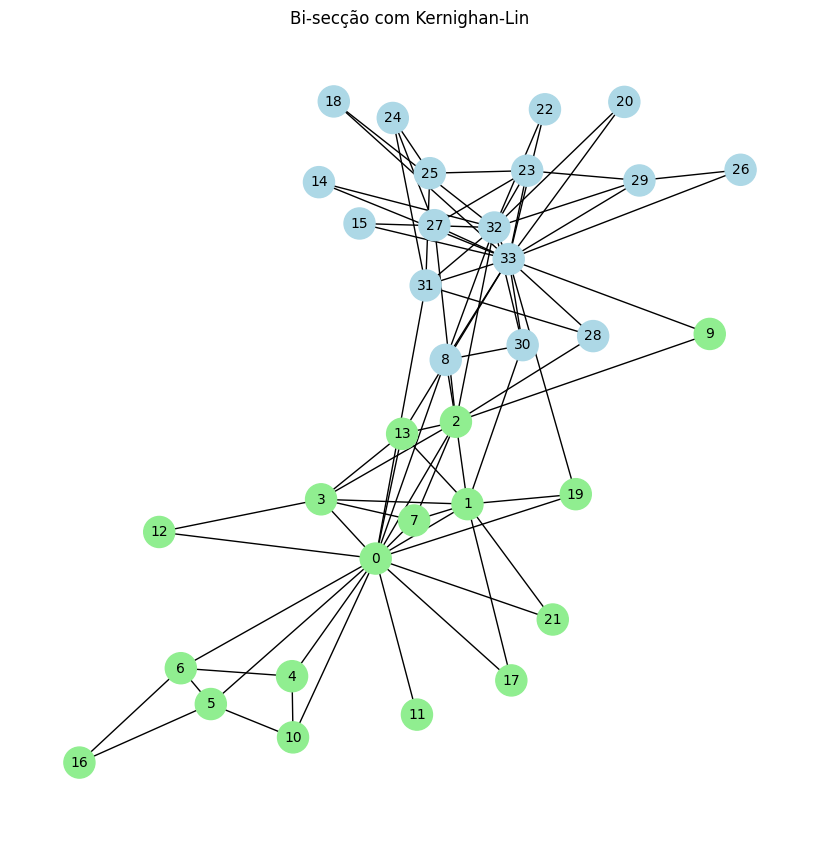

Comparação com a Partição Natural:
Grupo 1 da bi-secção: {8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
Grupo 2 da bi-secção: {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21}

Interseção Grupo 1 (Kernighan-Lin) e Mr. Hi: set()
Interseção Grupo 2 (Kernighan-Lin) e Officer: {16, 9, 10, 12}

Diferença Grupo 1 (Kernighan-Lin) e Mr. Hi: {32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Diferença Grupo 2 (Kernighan-Lin) e Officer: {0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 17, 19, 21}


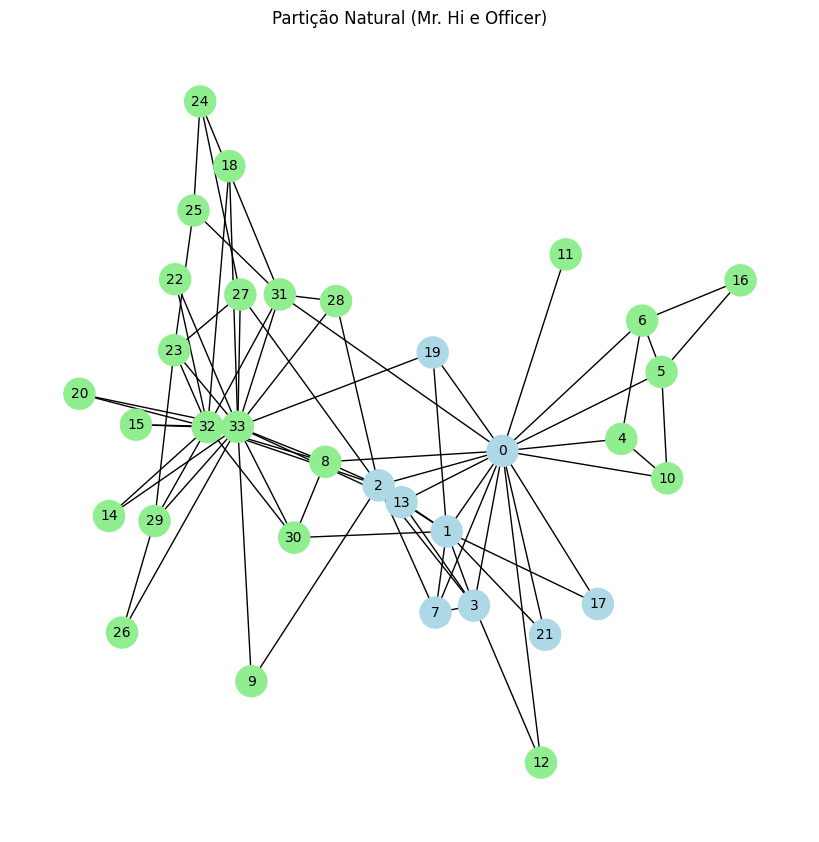

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import kernighan_lin_bisection

# Carregar a rede Zachary's Karate Club
G_karate = nx.karate_club_graph()

# Partição natural da rede Zachary's Karate Club (segundo o estudo original)
# Os nós são divididos em dois grupos: um grupo liderado pelo instrutor (grupo 'Mr. Hi')
# e o outro pelo administrador (grupo 'Officer').
natural_partition = {
    'Mr. Hi': {0, 1, 2, 3, 7, 13, 17, 19, 21},
    'Officer': {8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
}

# Obter a bi-secção usando o algoritmo de Kernighan-Lin
kl_bisection = kernighan_lin_bisection(G_karate)

# Converter para conjuntos para facilitar a comparação
kl_group1 = set(kl_bisection[0])
kl_group2 = set(kl_bisection[1])

# Desenhar o grafo e a bi-secção de Kernighan-Lin
def draw_partition(G, partition, title):
    pos = nx.spring_layout(G_karate)
    plt.figure(figsize=(8, 8))
    color_map = []

    for node in G.nodes():
        if node in partition[0]:
            color_map.append('lightblue')  # Grupo 1
        else:
            color_map.append('lightgreen')  # Grupo 2

    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10)
    plt.title(title)
    plt.show()

draw_partition(G_karate, kl_bisection, "Bi-secção com Kernighan-Lin")

# Comparando com a partição natural
natural_group1 = natural_partition['Mr. Hi']
natural_group2 = natural_partition['Officer']

# Função para calcular as interseções e diferenças
def compare_partitions(group1, group2, natural_group1, natural_group2):
    intersection_1 = group1.intersection(natural_group1)
    intersection_2 = group2.intersection(natural_group2)

    diff_1 = group1.difference(natural_group1)
    diff_2 = group2.difference(natural_group2)

    print("Comparação com a Partição Natural:")
    print(f"Grupo 1 da bi-secção: {group1}")
    print(f"Grupo 2 da bi-secção: {group2}\n")

    print(f"Interseção Grupo 1 (Kernighan-Lin) e Mr. Hi: {intersection_1}")
    print(f"Interseção Grupo 2 (Kernighan-Lin) e Officer: {intersection_2}\n")

    print(f"Diferença Grupo 1 (Kernighan-Lin) e Mr. Hi: {diff_1}")
    print(f"Diferença Grupo 2 (Kernighan-Lin) e Officer: {diff_2}")

# Comparar as partições
compare_partitions(kl_group1, kl_group2, natural_group1, natural_group2)

# Desenhar o grafo com a partição natural
def draw_natural_partition(G, natural_partition, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 8))

    # Colorir de acordo com os grupos naturais
    color_map = []
    for node in G.nodes():
        if node in natural_partition['Mr. Hi']:
            color_map.append('lightblue')  # Grupo 'Mr. Hi'
        else:
            color_map.append('lightgreen')  # Grupo 'Officer'

    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_size=10)
    plt.title(title)
    plt.show()

draw_natural_partition(G_karate, natural_partition, "Partição Natural (Mr. Hi e Officer)")
